### Name: Sihui Huang
### Uni: sh3573
### Email: sh3573@columbia.edu

# Sequence to Sequence Modelling

**Note**: All code should be in Python3. Keras version should be 2.0.4. The directory structure on the bitbucket repo should be exactly same as the hw4.zip provided to you (with the exception of data directory. Do not upload it). To push the code to remote repo, use the same instructions as given in HW0. **Double check you remote repo for correct directory structure. We won't consider any regrade requests based on wrong directory structure penalty. Again, do not upload data to your bitbucket repo ** <br>
**The data provided to you should not be used for any other purpose than this course. You must not distribute it or upload it to any public platform.**

In this assignment, we are going to solve the problem of summarization using a sequence to sequence model. In a sequence to sequence problem, we have an encoder and a decoder. We feed the sequence of word embeddings to an encoder and train decoder to learn the summaries. We will be seeing 2 types of encoder decoder architectures in this assignment

# Preparing Inputs
The first part of the assignment is to prepare data. You are given training data in train_article.txt, in which each line is the first sentence from an article, and training summary sentences in train_title.txt, which are the corresponding titles of the article. You will be training the model to predict the title of an article given the first sentence of that article, where title generation is a summarization task. Let us limit the maximum vocabulary size to 20000 and maximum length of article to 200 (These are just initial params to get you started and we recommend experimenting, to improve your scores after you are done with your first implementation)

In [1]:
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, TimeDistributed, Dense, RepeatVector, recurrent, Embedding
from keras.layers.recurrent import LSTM
from keras.optimizers import RMSprop
import numpy as np
import os
import datetime
import sys

MAX_LEN = 200
VOCAB_SIZE = 20000

Using TensorFlow backend.


Write a function which takes article file, summary file, maximum length of sentence and vocabulary size and does the following
* Create vocabulary: Take most frequent VOCAB_SIZE number of words from article file. Add two special symbols ZERO at start and UNK at end to finally have VOCAB_SIZE + 2 words. Use this array as idx2word. Repeat the process for summary data to create another idx2word corresponding to it. 
* Using the above idx2word for both article and summary data, create word2idx, which will map every word to its index in idx2word array. 
* Convert the words in the article and summary data to their corresponding index from word2idx. If a word is not present in the vocab, use the index of UNK. 
* After the above preprocessing, each sentence in article and summary data should be a list of indices
* Now find the max length of a sentence (which is basically number of indices in a sentence) in article data. Pad every sentence in article data to that length, so that all sentences are of same length. You may use pad_sequences function provided by keras. Do the same for title data.
* return the following outputs transformed article data, vocab size of article data, idx2word(articledata), word2idx(articledata),transformed summary data, vocab size of summary data, idx2word(summarydata), word2idx(summarydata)

reference: https://github.com/ChunML/seq2seq

In [ ]:
def load_data(source, dist, max_len, vocab_size):

    # Reading raw text from source and destination files
    f = open(source, 'r')
    X_data = f.read()
    f.close()
    f = open(dist, 'r')
    y_data = f.read()
    f.close()

    # Splitting raw text into array of sequences
    X = [text_to_word_sequence(x, filters='')[::-1] for x, y in zip(X_data.split('\n'), y_data.split('\n')) if len(x) > 0 and len(y) > 0 and len(x) <= max_len and len(y) <= max_len]
    y = [text_to_word_sequence(y, filters='') for x, y in zip(X_data.split('\n'), y_data.split('\n')) if len(x) > 0 and len(y) > 0 and len(x) <= max_len and len(y) <= max_len]

    # Creating the vocabulary set with the most common words
    dist = FreqDist(np.hstack(X))
    X_vocab = dist.most_common(vocab_size)
    dist = FreqDist(np.hstack(y))
    y_vocab = dist.most_common(vocab_size)

    # Creating an array of words from the vocabulary set, we will use this array as index-to-word dictionary
    X_ix_to_word = [word[0] for word in X_vocab]
    # Adding the word "ZERO" to the beginning of the array
    X_ix_to_word.insert(0, 'ZERO')
    # Adding the word 'UNK' to the end of the array (stands for UNKNOWN words)
    X_ix_to_word.append('UNK')

    # Creating the word-to-index dictionary from the array created above
    X_word_to_ix = {word:ix for ix, word in enumerate(X_ix_to_word)}

    # Converting each word to its index value
    for i, sentence in enumerate(X):
        for j, word in enumerate(sentence):
            if word in X_word_to_ix:
                X[i][j] = X_word_to_ix[word]
            else:
                X[i][j] = X_word_to_ix['UNK']

    y_ix_to_word = [word[0] for word in y_vocab]
    y_ix_to_word.insert(0, 'ZERO')
    y_ix_to_word.append('UNK')
    y_word_to_ix = {word:ix for ix, word in enumerate(y_ix_to_word)}
    for i, sentence in enumerate(y):
        for j, word in enumerate(sentence):
            if word in y_word_to_ix:
                y[i][j] = y_word_to_ix[word]
            else:
                y[i][j] = y_word_to_ix['UNK']
    return (X, len(X_vocab)+2, X_word_to_ix, X_ix_to_word, y, len(y_vocab)+2, y_word_to_ix, y_ix_to_word)

def load_test_data(source, X_word_to_ix, max_len):
    f = open(source, 'r')
    X_data = f.read()
    f.close()

    X = [text_to_word_sequence(x, filters='')[::-1] for x in X_data.split('\n') if len(x) > 0 and len(x) <= max_len]
    for i, sentence in enumerate(X):
        for j, word in enumerate(sentence):
            if word in X_word_to_ix:
                X[i][j] = X_word_to_ix[word]
            else:
                X[i][j] = X_word_to_ix['UNK']
    return X

def process_data(word_sentences, max_len, word_to_ix):
    # Vectorizing each element in each sequence
    sequences = np.zeros((len(word_sentences), max_len, len(word_to_ix)))
    for i, sentence in enumerate(word_sentences):
        for j, word in enumerate(sentence):
            sequences[i, j, word] = 1.
    return sequences

Now use the above function to load the training data from article and summary (i.e. title) files. Do note that, based on your model architecture, you may need to further one-hot vectorize your input to the model

In [3]:
print('[INFO] Loading data...')
X, X_vocab_len, X_word_to_ix, X_ix_to_word, y, y_vocab_len, y_word_to_ix, y_ix_to_word = load_data('data/train_article.txt', 'data/train_title.txt', MAX_LEN, VOCAB_SIZE)

# Finding the length of the longest sequence
X_max_len = max([len(sentence) for sentence in X])
y_max_len = max([len(sentence) for sentence in y])

# Padding zeros to make all sequences have a same length with the longest one
print('[INFO] Zero padding...')
X = pad_sequences(X, maxlen=X_max_len, dtype='int32', padding='post')
y = pad_sequences(y, maxlen=y_max_len, dtype='int32', padding='post')


[INFO] Loading data...
[INFO] Zero padding...


In [4]:
print(X.shape)
print(y.shape)

(50000, 24)
(50000, 32)


# Unidirectional LSTM Encoder Decoder
Define the parameters for your LSTM encoder decoder model.

In [5]:
BATCH_SIZE = 256
LAYER_NUM = 4
HIDDEN_DIM = 512
NB_EPOCH = 40

Create a Unidirectional encoder decoder LSTM model in create_model function. The model should have a LSTM Unidirectional layer as encoder and a LSTM decoder. Use categorical_cross_entropy loss and experiment with different optimizers to improve your score.

In [6]:
def create_UniLSTM(X_vocab_len, X_max_len, y_vocab_len, y_max_len, hidden_size, num_layers):
    model = Sequential()

    # Creating encoder network
    model.add(Embedding(X_vocab_len, hidden_size, input_length=X_max_len, mask_zero=True))
    model.add(LSTM(hidden_size))
    model.add(RepeatVector(y_max_len))

    # Creating decoder network
    for _ in range(num_layers):
        model.add(LSTM(hidden_size, return_sequences=True))
    model.add(TimeDistributed(Dense(y_vocab_len)))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
            optimizer='rmsprop',
            metrics=['accuracy'])
    return model

# create_UniLSTMwithAttention

In [7]:
# Creating the network model
print('[INFO] Compiling model...')
model = create_UniLSTM(X_vocab_len, X_max_len, y_vocab_len, y_max_len, HIDDEN_DIM, LAYER_NUM)


[INFO] Compiling model...


# Train the Model
Now that we have everything in place, we can run our model. We recommend training the model in batches instead of training on all 50,000 article-title pairs at once, if you encounter memory contraints

In [13]:
from keras.callbacks import TensorBoard

#tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)

checkpoint = ModelCheckpoint('./weight/without_attention_weight.hdf5', 
                             save_weights_only=True, save_best_only=True, monitor='loss')

k_start = 1
for k in range(k_start, NB_EPOCH+1):
    # Shuffling the training data every epoch to avoid local minima
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    # Training 1000 sequences at a time
    for i in range(0, len(X), 1000):
        if i + 1000 >= len(X):
            i_end = len(X)
        else:
            i_end = i + 1000
        y_sequences = process_data(y[i:i_end], y_max_len, y_word_to_ix)

        print('[INFO] Training model: epoch {}th {}/{} samples'.format(k, i, len(X)))
        #model.fit(X[i:i_end], y_sequences, batch_size=BATCH_SIZE, nb_epoch=1, validation_split=0.1, callbacks=[tensorboard])
        model.fit(X[i:i_end], y_sequences, batch_size=BATCH_SIZE, nb_epoch=1, validation_split=0.2, callbacks=[checkpoint])
        

[INFO] Training model: epoch 1th 0/50000 samples


/usr/local/lib/python3.4/dist-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 14s - loss: 8.8177 - acc: 0.5246 - val_loss: 2.8536 - val_acc: 0.7686
[INFO] Training model: epoch 1th 1000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.5546 - acc: 0.7676 - val_loss: 2.3277 - val_acc: 0.7697
[INFO] Training model: epoch 1th 2000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.3265 - acc: 0.7689 - val_loss: 2.2440 - val_acc: 0.7720
[INFO] Training model: epoch 1th 3000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.2901 - acc: 0.7678 - val_loss: 2.2782 - val_acc: 0.7605
[INFO] Training model: epoch 1th 4000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 2.3058 - 

800/800 [==============================] - 9s - loss: 1.9325 - acc: 0.7722 - val_loss: 1.8689 - val_acc: 0.7802
[INFO] Training model: epoch 1th 38000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.9319 - acc: 0.7725 - val_loss: 1.8949 - val_acc: 0.7780
[INFO] Training model: epoch 1th 39000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.9314 - acc: 0.7732 - val_loss: 1.9021 - val_acc: 0.7706
[INFO] Training model: epoch 1th 40000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.9378 - acc: 0.7718 - val_loss: 1.9747 - val_acc: 0.7727
[INFO] Training model: epoch 1th 41000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.9448 - acc: 0.7730 - val_loss: 1.8997 - val_acc: 0.7750
[INF

800/800 [==============================] - 9s - loss: 1.8110 - acc: 0.7754 - val_loss: 1.8601 - val_acc: 0.7745
[INFO] Training model: epoch 3th 12000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.8748 - acc: 0.7718 - val_loss: 1.7414 - val_acc: 0.7881
[INFO] Training model: epoch 3th 13000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.8232 - acc: 0.7758 - val_loss: 1.9247 - val_acc: 0.7680
[INFO] Training model: epoch 3th 14000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.8541 - acc: 0.7733 - val_loss: 1.8116 - val_acc: 0.7784
[INFO] Training model: epoch 3th 15000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.8417 - acc: 0.7750 - val_loss: 1.7498 - val_acc: 0.7887
[INF

800/800 [==============================] - 9s - loss: 1.7911 - acc: 0.7770 - val_loss: 1.7698 - val_acc: 0.7792
[INFO] Training model: epoch 4th 36000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.8216 - acc: 0.7741 - val_loss: 1.7879 - val_acc: 0.7791
[INFO] Training model: epoch 4th 37000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.8436 - acc: 0.7738 - val_loss: 1.7852 - val_acc: 0.7792
[INFO] Training model: epoch 4th 38000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.8086 - acc: 0.7770 - val_loss: 1.7255 - val_acc: 0.7828
[INFO] Training model: epoch 4th 39000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.7900 - acc: 0.7777 - val_loss: 1.8628 - val_acc: 0.7728
[INF

800/800 [==============================] - 9s - loss: 1.7566 - acc: 0.7766 - val_loss: 1.7961 - val_acc: 0.7742
[INFO] Training model: epoch 6th 10000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.7469 - acc: 0.7764 - val_loss: 1.7571 - val_acc: 0.7786
[INFO] Training model: epoch 6th 11000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.7365 - acc: 0.7782 - val_loss: 1.7216 - val_acc: 0.7814
[INFO] Training model: epoch 6th 12000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.7100 - acc: 0.7787 - val_loss: 1.8003 - val_acc: 0.7700
[INFO] Training model: epoch 6th 13000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.7386 - acc: 0.7764 - val_loss: 1.7212 - val_acc: 0.7780
[INF

800/800 [==============================] - 9s - loss: 1.7112 - acc: 0.7799 - val_loss: 1.7540 - val_acc: 0.7827
[INFO] Training model: epoch 7th 34000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.7696 - acc: 0.7774 - val_loss: 1.8147 - val_acc: 0.7700
[INFO] Training model: epoch 7th 35000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.7004 - acc: 0.7825 - val_loss: 1.6954 - val_acc: 0.7795
[INFO] Training model: epoch 7th 36000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.7079 - acc: 0.7812 - val_loss: 1.6440 - val_acc: 0.7900
[INFO] Training model: epoch 7th 37000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.7313 - acc: 0.7784 - val_loss: 1.8032 - val_acc: 0.7727
[INF

800/800 [==============================] - 9s - loss: 1.7105 - acc: 0.7757 - val_loss: 1.6545 - val_acc: 0.7856
[INFO] Training model: epoch 9th 8000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.6403 - acc: 0.7846 - val_loss: 1.6080 - val_acc: 0.7852
[INFO] Training model: epoch 9th 9000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.7040 - acc: 0.7786 - val_loss: 1.6793 - val_acc: 0.7845
[INFO] Training model: epoch 9th 10000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.7037 - acc: 0.7774 - val_loss: 1.6514 - val_acc: 0.7828
[INFO] Training model: epoch 9th 11000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.6715 - acc: 0.7813 - val_loss: 1.7627 - val_acc: 0.7731
[INFO]

800/800 [==============================] - 9s - loss: 1.6515 - acc: 0.7817 - val_loss: 1.6173 - val_acc: 0.7841
[INFO] Training model: epoch 10th 32000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.6959 - acc: 0.7788 - val_loss: 1.7179 - val_acc: 0.7759
[INFO] Training model: epoch 10th 33000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.6122 - acc: 0.7886 - val_loss: 1.6143 - val_acc: 0.7880
[INFO] Training model: epoch 10th 34000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.6072 - acc: 0.7883 - val_loss: 1.6917 - val_acc: 0.7839
[INFO] Training model: epoch 10th 35000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.6902 - acc: 0.7796 - val_loss: 1.6221 - val_acc: 0.7862


800/800 [==============================] - 9s - loss: 1.6597 - acc: 0.7795 - val_loss: 1.7357 - val_acc: 0.7750
[INFO] Training model: epoch 11th 19000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.6235 - acc: 0.7827 - val_loss: 1.6572 - val_acc: 0.7823
[INFO] Training model: epoch 11th 20000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.6370 - acc: 0.7815 - val_loss: 1.6873 - val_acc: 0.7803
[INFO] Training model: epoch 11th 21000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.6424 - acc: 0.7827 - val_loss: 1.6390 - val_acc: 0.7822
[INFO] Training model: epoch 11th 22000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.6343 - acc: 0.7841 - val_loss: 1.6743 - val_acc: 0.7789


800/800 [==============================] - 9s - loss: 1.5978 - acc: 0.7838 - val_loss: 1.5385 - val_acc: 0.7909
[INFO] Training model: epoch 12th 6000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.6195 - acc: 0.7821 - val_loss: 1.5473 - val_acc: 0.7892
[INFO] Training model: epoch 12th 7000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.6451 - acc: 0.7805 - val_loss: 1.6466 - val_acc: 0.7772
[INFO] Training model: epoch 12th 8000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.5874 - acc: 0.7823 - val_loss: 1.6411 - val_acc: 0.7811
[INFO] Training model: epoch 12th 9000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.6290 - acc: 0.7818 - val_loss: 1.6848 - val_acc: 0.7727
[INF

800/800 [==============================] - 9s - loss: 1.6312 - acc: 0.7829 - val_loss: 1.6125 - val_acc: 0.7862
[INFO] Training model: epoch 12th 43000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.6101 - acc: 0.7863 - val_loss: 1.6270 - val_acc: 0.7881
[INFO] Training model: epoch 12th 44000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.6455 - acc: 0.7808 - val_loss: 1.6488 - val_acc: 0.7778
[INFO] Training model: epoch 12th 45000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 10s - loss: 1.6394 - acc: 0.7822 - val_loss: 1.6537 - val_acc: 0.7833
[INFO] Training model: epoch 12th 46000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.6390 - acc: 0.7805 - val_loss: 1.6431 - val_acc: 0.7869

800/800 [==============================] - 9s - loss: 1.6079 - acc: 0.7833 - val_loss: 1.7520 - val_acc: 0.7731
[INFO] Training model: epoch 13th 30000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.6118 - acc: 0.7835 - val_loss: 1.6403 - val_acc: 0.7812
[INFO] Training model: epoch 13th 31000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 10s - loss: 1.6047 - acc: 0.7820 - val_loss: 1.6453 - val_acc: 0.7775
[INFO] Training model: epoch 13th 32000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.6039 - acc: 0.7837 - val_loss: 1.5615 - val_acc: 0.7877
[INFO] Training model: epoch 13th 33000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.5526 - acc: 0.7904 - val_loss: 1.5580 - val_acc: 0.7889

800/800 [==============================] - 9s - loss: 1.5725 - acc: 0.7848 - val_loss: 1.5846 - val_acc: 0.7823
[INFO] Training model: epoch 14th 17000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.5674 - acc: 0.7858 - val_loss: 1.6433 - val_acc: 0.7822
[INFO] Training model: epoch 14th 18000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.6135 - acc: 0.7813 - val_loss: 1.6382 - val_acc: 0.7773
[INFO] Training model: epoch 14th 19000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 10s - loss: 1.5858 - acc: 0.7827 - val_loss: 1.6853 - val_acc: 0.7744
[INFO] Training model: epoch 14th 20000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.5866 - acc: 0.7839 - val_loss: 1.6354 - val_acc: 0.7784

800/800 [==============================] - 9s - loss: 1.5373 - acc: 0.7889 - val_loss: 1.6188 - val_acc: 0.7764
[INFO] Training model: epoch 15th 4000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.5168 - acc: 0.7895 - val_loss: 1.5480 - val_acc: 0.7867
[INFO] Training model: epoch 15th 5000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.5522 - acc: 0.7855 - val_loss: 1.5729 - val_acc: 0.7842
[INFO] Training model: epoch 15th 6000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.5356 - acc: 0.7888 - val_loss: 1.5936 - val_acc: 0.7825
[INFO] Training model: epoch 15th 7000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.5535 - acc: 0.7860 - val_loss: 1.5132 - val_acc: 0.7895
[INF

800/800 [==============================] - 9s - loss: 1.5801 - acc: 0.7855 - val_loss: 1.5729 - val_acc: 0.7873
[INFO] Training model: epoch 15th 41000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.5753 - acc: 0.7836 - val_loss: 1.6110 - val_acc: 0.7841
[INFO] Training model: epoch 15th 42000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.5739 - acc: 0.7859 - val_loss: 1.6060 - val_acc: 0.7819
[INFO] Training model: epoch 15th 43000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.5808 - acc: 0.7838 - val_loss: 1.4881 - val_acc: 0.7927
[INFO] Training model: epoch 15th 44000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.6025 - acc: 0.7834 - val_loss: 1.5918 - val_acc: 0.7814


800/800 [==============================] - 9s - loss: 1.5737 - acc: 0.7850 - val_loss: 1.5690 - val_acc: 0.7834
[INFO] Training model: epoch 16th 28000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.5292 - acc: 0.7898 - val_loss: 1.5264 - val_acc: 0.7931
[INFO] Training model: epoch 16th 29000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.5417 - acc: 0.7861 - val_loss: 1.5948 - val_acc: 0.7809
[INFO] Training model: epoch 16th 30000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.5597 - acc: 0.7855 - val_loss: 1.5314 - val_acc: 0.7923
[INFO] Training model: epoch 16th 31000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.5619 - acc: 0.7838 - val_loss: 1.5517 - val_acc: 0.7891


800/800 [==============================] - 10s - loss: 1.4852 - acc: 0.7921 - val_loss: 1.5319 - val_acc: 0.7884
[INFO] Training model: epoch 17th 15000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 10s - loss: 1.5370 - acc: 0.7841 - val_loss: 1.6128 - val_acc: 0.7797
[INFO] Training model: epoch 17th 16000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.5438 - acc: 0.7854 - val_loss: 1.5727 - val_acc: 0.7752
[INFO] Training model: epoch 17th 17000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.5291 - acc: 0.7881 - val_loss: 1.6249 - val_acc: 0.7769
[INFO] Training model: epoch 17th 18000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.4790 - acc: 0.7946 - val_loss: 1.5159 - val_acc: 0.783

800/800 [==============================] - 9s - loss: 1.5187 - acc: 0.7838 - val_loss: 1.4542 - val_acc: 0.7903
[INFO] Training model: epoch 18th 2000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.5191 - acc: 0.7847 - val_loss: 1.5462 - val_acc: 0.7827
[INFO] Training model: epoch 18th 3000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.5198 - acc: 0.7855 - val_loss: 1.5534 - val_acc: 0.7802
[INFO] Training model: epoch 18th 4000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.5351 - acc: 0.7855 - val_loss: 1.5205 - val_acc: 0.7845
[INFO] Training model: epoch 18th 5000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.5312 - acc: 0.7856 - val_loss: 1.5643 - val_acc: 0.7769
[INF

800/800 [==============================] - 10s - loss: 1.5464 - acc: 0.7848 - val_loss: 1.5417 - val_acc: 0.7825
[INFO] Training model: epoch 18th 39000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 10s - loss: 1.5350 - acc: 0.7853 - val_loss: 1.4708 - val_acc: 0.7992
[INFO] Training model: epoch 18th 40000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.5432 - acc: 0.7879 - val_loss: 1.5501 - val_acc: 0.7847
[INFO] Training model: epoch 18th 41000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.5075 - acc: 0.7904 - val_loss: 1.5801 - val_acc: 0.7856
[INFO] Training model: epoch 18th 42000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.5261 - acc: 0.7882 - val_loss: 1.5651 - val_acc: 0.787

800/800 [==============================] - 10s - loss: 1.5165 - acc: 0.7854 - val_loss: 1.4207 - val_acc: 0.7966
[INFO] Training model: epoch 19th 26000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 10s - loss: 1.5098 - acc: 0.7898 - val_loss: 1.5446 - val_acc: 0.7848
[INFO] Training model: epoch 19th 27000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.5050 - acc: 0.7905 - val_loss: 1.5738 - val_acc: 0.7805
[INFO] Training model: epoch 19th 28000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.4922 - acc: 0.7901 - val_loss: 1.4653 - val_acc: 0.7941
[INFO] Training model: epoch 19th 29000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.4847 - acc: 0.7901 - val_loss: 1.5321 - val_acc: 0.784

800/800 [==============================] - 9s - loss: 1.4792 - acc: 0.7920 - val_loss: 1.4721 - val_acc: 0.7908
[INFO] Training model: epoch 20th 13000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.4843 - acc: 0.7901 - val_loss: 1.5111 - val_acc: 0.7850
[INFO] Training model: epoch 20th 14000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.4675 - acc: 0.7883 - val_loss: 1.5022 - val_acc: 0.7873
[INFO] Training model: epoch 20th 15000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.4597 - acc: 0.7913 - val_loss: 1.4644 - val_acc: 0.7892
[INFO] Training model: epoch 20th 16000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.4593 - acc: 0.7917 - val_loss: 1.5452 - val_acc: 0.7841


800/800 [==============================] - 9s - loss: 1.4778 - acc: 0.7932 - val_loss: 1.5607 - val_acc: 0.7869
[INFO] Training model: epoch 21th 0/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 10s - loss: 1.4348 - acc: 0.7922 - val_loss: 1.3844 - val_acc: 0.7997
[INFO] Training model: epoch 21th 1000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 10s - loss: 1.4760 - acc: 0.7882 - val_loss: 1.4184 - val_acc: 0.7942
[INFO] Training model: epoch 21th 2000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.4611 - acc: 0.7862 - val_loss: 1.4694 - val_acc: 0.7850
[INFO] Training model: epoch 21th 3000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 10s - loss: 1.4691 - acc: 0.7865 - val_loss: 1.4190 - val_acc: 0.7994
[INF

800/800 [==============================] - 9s - loss: 1.4782 - acc: 0.7909 - val_loss: 1.5325 - val_acc: 0.7827
[INFO] Training model: epoch 21th 37000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.4809 - acc: 0.7904 - val_loss: 1.5482 - val_acc: 0.7830
[INFO] Training model: epoch 21th 38000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.4913 - acc: 0.7882 - val_loss: 1.4799 - val_acc: 0.7900
[INFO] Training model: epoch 21th 39000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.4950 - acc: 0.7903 - val_loss: 1.4858 - val_acc: 0.7917
[INFO] Training model: epoch 21th 40000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 10s - loss: 1.5031 - acc: 0.7869 - val_loss: 1.5009 - val_acc: 0.7837

800/800 [==============================] - 10s - loss: 1.4553 - acc: 0.7928 - val_loss: 1.4835 - val_acc: 0.7934
[INFO] Training model: epoch 22th 24000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 10s - loss: 1.4436 - acc: 0.7959 - val_loss: 1.4520 - val_acc: 0.7934
[INFO] Training model: epoch 22th 25000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 10s - loss: 1.4781 - acc: 0.7881 - val_loss: 1.4066 - val_acc: 0.8006
[INFO] Training model: epoch 22th 26000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.4880 - acc: 0.7882 - val_loss: 1.4098 - val_acc: 0.7952
[INFO] Training model: epoch 22th 27000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 10s - loss: 1.4485 - acc: 0.7916 - val_loss: 1.5249 - val_acc: 0.7

800/800 [==============================] - 10s - loss: 1.4105 - acc: 0.7945 - val_loss: 1.4230 - val_acc: 0.7883
[INFO] Training model: epoch 23th 11000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.4502 - acc: 0.7894 - val_loss: 1.4756 - val_acc: 0.7825
[INFO] Training model: epoch 23th 12000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 10s - loss: 1.4686 - acc: 0.7848 - val_loss: 1.5034 - val_acc: 0.7855
[INFO] Training model: epoch 23th 13000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.4533 - acc: 0.7885 - val_loss: 1.4925 - val_acc: 0.7859
[INFO] Training model: epoch 23th 14000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 10s - loss: 1.4512 - acc: 0.7913 - val_loss: 1.4635 - val_acc: 0.78

800/800 [==============================] - 10s - loss: 1.4976 - acc: 0.7884 - val_loss: 1.4487 - val_acc: 0.7933
[INFO] Training model: epoch 23th 48000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.4472 - acc: 0.7930 - val_loss: 1.4539 - val_acc: 0.7950
[INFO] Training model: epoch 23th 49000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 10s - loss: 1.4486 - acc: 0.7929 - val_loss: 1.4855 - val_acc: 0.7891
[INFO] Training model: epoch 24th 0/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.4374 - acc: 0.7877 - val_loss: 1.4967 - val_acc: 0.7841
[INFO] Training model: epoch 24th 1000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.3975 - acc: 0.7943 - val_loss: 1.3562 - val_acc: 0.7986
[IN

800/800 [==============================] - 10s - loss: 1.4947 - acc: 0.7855 - val_loss: 1.4469 - val_acc: 0.7911
[INFO] Training model: epoch 24th 35000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 10s - loss: 1.4326 - acc: 0.7930 - val_loss: 1.4566 - val_acc: 0.7931
[INFO] Training model: epoch 24th 36000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 10s - loss: 1.4978 - acc: 0.7853 - val_loss: 1.4581 - val_acc: 0.7958
[INFO] Training model: epoch 24th 37000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 10s - loss: 1.5251 - acc: 0.7815 - val_loss: 1.3685 - val_acc: 0.7966
[INFO] Training model: epoch 24th 38000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 10s - loss: 1.4518 - acc: 0.7886 - val_loss: 1.4814 - val_acc: 0.

800/800 [==============================] - 9s - loss: 1.4351 - acc: 0.7900 - val_loss: 1.4169 - val_acc: 0.7931
[INFO] Training model: epoch 25th 22000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 10s - loss: 1.4444 - acc: 0.7881 - val_loss: 1.4307 - val_acc: 0.7881
[INFO] Training model: epoch 25th 23000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 10s - loss: 1.4766 - acc: 0.7856 - val_loss: 1.4395 - val_acc: 0.7903
[INFO] Training model: epoch 25th 24000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.4547 - acc: 0.7871 - val_loss: 1.4535 - val_acc: 0.7917
[INFO] Training model: epoch 25th 25000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.4567 - acc: 0.7900 - val_loss: 1.4148 - val_acc: 0.796

800/800 [==============================] - 9s - loss: 1.3764 - acc: 0.7950 - val_loss: 1.4828 - val_acc: 0.7816
[INFO] Training model: epoch 26th 9000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.3869 - acc: 0.7928 - val_loss: 1.4970 - val_acc: 0.7805
[INFO] Training model: epoch 26th 10000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.4376 - acc: 0.7868 - val_loss: 1.4418 - val_acc: 0.7927
[INFO] Training model: epoch 26th 11000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.4178 - acc: 0.7904 - val_loss: 1.4800 - val_acc: 0.7814
[INFO] Training model: epoch 26th 12000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.3710 - acc: 0.7936 - val_loss: 1.4355 - val_acc: 0.7875
[

800/800 [==============================] - 9s - loss: 1.4097 - acc: 0.7949 - val_loss: 1.3707 - val_acc: 0.7969
[INFO] Training model: epoch 26th 46000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.4489 - acc: 0.7913 - val_loss: 1.4242 - val_acc: 0.7980
[INFO] Training model: epoch 26th 47000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.4285 - acc: 0.7909 - val_loss: 1.4538 - val_acc: 0.7892
[INFO] Training model: epoch 26th 48000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.4907 - acc: 0.7839 - val_loss: 1.4296 - val_acc: 0.7922
[INFO] Training model: epoch 26th 49000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.4523 - acc: 0.7893 - val_loss: 1.4386 - val_acc: 0.7941


800/800 [==============================] - 9s - loss: 1.3902 - acc: 0.7947 - val_loss: 1.4700 - val_acc: 0.7867
[INFO] Training model: epoch 27th 33000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.4754 - acc: 0.7851 - val_loss: 1.4166 - val_acc: 0.7972
[INFO] Training model: epoch 27th 34000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.4390 - acc: 0.7892 - val_loss: 1.4595 - val_acc: 0.7884
[INFO] Training model: epoch 27th 35000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.4220 - acc: 0.7925 - val_loss: 1.4201 - val_acc: 0.7945
[INFO] Training model: epoch 27th 36000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.4638 - acc: 0.7877 - val_loss: 1.3520 - val_acc: 0.8006


800/800 [==============================] - 9s - loss: 1.3876 - acc: 0.7929 - val_loss: 1.3130 - val_acc: 0.8012
[INFO] Training model: epoch 28th 20000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.3840 - acc: 0.7937 - val_loss: 1.4084 - val_acc: 0.7967
[INFO] Training model: epoch 28th 21000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.4375 - acc: 0.7883 - val_loss: 1.3891 - val_acc: 0.7952
[INFO] Training model: epoch 28th 22000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.4147 - acc: 0.7897 - val_loss: 1.3905 - val_acc: 0.7950
[INFO] Training model: epoch 28th 23000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.4053 - acc: 0.7923 - val_loss: 1.4177 - val_acc: 0.7886


800/800 [==============================] - 9s - loss: 1.3875 - acc: 0.7924 - val_loss: 1.3709 - val_acc: 0.7933
[INFO] Training model: epoch 29th 7000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.3443 - acc: 0.7950 - val_loss: 1.3358 - val_acc: 0.7948
[INFO] Training model: epoch 29th 8000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.3543 - acc: 0.7964 - val_loss: 1.3930 - val_acc: 0.7900
[INFO] Training model: epoch 29th 9000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.3957 - acc: 0.7904 - val_loss: 1.4533 - val_acc: 0.7856
[INFO] Training model: epoch 29th 10000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.3748 - acc: 0.7937 - val_loss: 1.3677 - val_acc: 0.7912
[IN

800/800 [==============================] - 9s - loss: 1.4172 - acc: 0.7917 - val_loss: 1.4292 - val_acc: 0.7837
[INFO] Training model: epoch 29th 44000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 10s - loss: 1.3670 - acc: 0.7995 - val_loss: 1.4309 - val_acc: 0.7858
[INFO] Training model: epoch 29th 45000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.4178 - acc: 0.7927 - val_loss: 1.3494 - val_acc: 0.7964
[INFO] Training model: epoch 29th 46000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.3788 - acc: 0.7967 - val_loss: 1.4799 - val_acc: 0.7844
[INFO] Training model: epoch 29th 47000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.4213 - acc: 0.7916 - val_loss: 1.4555 - val_acc: 0.7881

800/800 [==============================] - 9s - loss: 1.3854 - acc: 0.7921 - val_loss: 1.3164 - val_acc: 0.8047
[INFO] Training model: epoch 30th 31000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.4024 - acc: 0.7909 - val_loss: 1.4114 - val_acc: 0.7881
[INFO] Training model: epoch 30th 32000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 10s - loss: 1.4024 - acc: 0.7919 - val_loss: 1.4120 - val_acc: 0.7872
[INFO] Training model: epoch 30th 33000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.3662 - acc: 0.7938 - val_loss: 1.3830 - val_acc: 0.7970
[INFO] Training model: epoch 30th 34000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.3872 - acc: 0.7949 - val_loss: 1.4792 - val_acc: 0.7859

800/800 [==============================] - 10s - loss: 1.3899 - acc: 0.7918 - val_loss: 1.4181 - val_acc: 0.7858
[INFO] Training model: epoch 31th 18000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 10s - loss: 1.3489 - acc: 0.7948 - val_loss: 1.3787 - val_acc: 0.7870
[INFO] Training model: epoch 31th 19000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 10s - loss: 1.3902 - acc: 0.7902 - val_loss: 1.3630 - val_acc: 0.7969
[INFO] Training model: epoch 31th 20000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 10s - loss: 1.3616 - acc: 0.7953 - val_loss: 1.3572 - val_acc: 0.7986
[INFO] Training model: epoch 31th 21000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 10s - loss: 1.3398 - acc: 0.7965 - val_loss: 1.3756 - val_acc: 0.

800/800 [==============================] - 9s - loss: 1.3114 - acc: 0.7977 - val_loss: 1.4171 - val_acc: 0.7905
[INFO] Training model: epoch 32th 5000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.3364 - acc: 0.7935 - val_loss: 1.3877 - val_acc: 0.7892
[INFO] Training model: epoch 32th 6000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.3573 - acc: 0.7936 - val_loss: 1.3808 - val_acc: 0.7972
[INFO] Training model: epoch 32th 7000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.3023 - acc: 0.8013 - val_loss: 1.3397 - val_acc: 0.7937
[INFO] Training model: epoch 32th 8000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.3530 - acc: 0.7944 - val_loss: 1.3618 - val_acc: 0.7942
[INF

800/800 [==============================] - 9s - loss: 1.3867 - acc: 0.7944 - val_loss: 1.4350 - val_acc: 0.7861
[INFO] Training model: epoch 32th 42000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.4314 - acc: 0.7890 - val_loss: 1.4066 - val_acc: 0.7897
[INFO] Training model: epoch 32th 43000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.3925 - acc: 0.7911 - val_loss: 1.4293 - val_acc: 0.7880
[INFO] Training model: epoch 32th 44000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.3799 - acc: 0.7942 - val_loss: 1.3615 - val_acc: 0.7987
[INFO] Training model: epoch 32th 45000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.3753 - acc: 0.7957 - val_loss: 1.4965 - val_acc: 0.7775


800/800 [==============================] - 9s - loss: 1.3554 - acc: 0.7950 - val_loss: 1.4326 - val_acc: 0.7803
[INFO] Training model: epoch 33th 29000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.3301 - acc: 0.7998 - val_loss: 1.3222 - val_acc: 0.8009
[INFO] Training model: epoch 33th 30000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.3819 - acc: 0.7907 - val_loss: 1.3662 - val_acc: 0.7950
[INFO] Training model: epoch 33th 31000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.3719 - acc: 0.7939 - val_loss: 1.3753 - val_acc: 0.7931
[INFO] Training model: epoch 33th 32000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.3374 - acc: 0.7995 - val_loss: 1.4337 - val_acc: 0.7877


800/800 [==============================] - 9s - loss: 1.3354 - acc: 0.7968 - val_loss: 1.3055 - val_acc: 0.8000
[INFO] Training model: epoch 34th 16000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.3835 - acc: 0.7895 - val_loss: 1.4198 - val_acc: 0.7869
[INFO] Training model: epoch 34th 17000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.3668 - acc: 0.7896 - val_loss: 1.2949 - val_acc: 0.8009
[INFO] Training model: epoch 34th 18000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.3621 - acc: 0.7929 - val_loss: 1.3351 - val_acc: 0.7942
[INFO] Training model: epoch 34th 19000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.3429 - acc: 0.7951 - val_loss: 1.4172 - val_acc: 0.7852


800/800 [==============================] - 9s - loss: 1.3182 - acc: 0.7936 - val_loss: 1.2211 - val_acc: 0.8102
[INFO] Training model: epoch 35th 3000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 10s - loss: 1.2907 - acc: 0.7989 - val_loss: 1.3353 - val_acc: 0.7934
[INFO] Training model: epoch 35th 4000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 10s - loss: 1.3441 - acc: 0.7898 - val_loss: 1.3078 - val_acc: 0.7928
[INFO] Training model: epoch 35th 5000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 10s - loss: 1.2822 - acc: 0.7988 - val_loss: 1.3067 - val_acc: 0.7986
[INFO] Training model: epoch 35th 6000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 10s - loss: 1.2739 - acc: 0.8009 - val_loss: 1.2784 - val_acc: 0.8025


800/800 [==============================] - 9s - loss: 1.3282 - acc: 0.7996 - val_loss: 1.3328 - val_acc: 0.8002
[INFO] Training model: epoch 35th 40000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.3643 - acc: 0.7913 - val_loss: 1.3694 - val_acc: 0.7944
[INFO] Training model: epoch 35th 41000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.3410 - acc: 0.7964 - val_loss: 1.4521 - val_acc: 0.7881
[INFO] Training model: epoch 35th 42000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.3396 - acc: 0.8000 - val_loss: 1.4141 - val_acc: 0.7933
[INFO] Training model: epoch 35th 43000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.3255 - acc: 0.7989 - val_loss: 1.3465 - val_acc: 0.7925


800/800 [==============================] - 9s - loss: 1.2988 - acc: 0.8006 - val_loss: 1.3003 - val_acc: 0.8033
[INFO] Training model: epoch 36th 27000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.3444 - acc: 0.7936 - val_loss: 1.2935 - val_acc: 0.8055
[INFO] Training model: epoch 36th 28000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 10s - loss: 1.3048 - acc: 0.7975 - val_loss: 1.3448 - val_acc: 0.7945
[INFO] Training model: epoch 36th 29000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.3417 - acc: 0.7949 - val_loss: 1.3824 - val_acc: 0.7917
[INFO] Training model: epoch 36th 30000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.3162 - acc: 0.7966 - val_loss: 1.3739 - val_acc: 0.7917

800/800 [==============================] - 10s - loss: 1.2867 - acc: 0.7990 - val_loss: 1.3285 - val_acc: 0.7947
[INFO] Training model: epoch 37th 14000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 10s - loss: 1.2802 - acc: 0.7994 - val_loss: 1.2630 - val_acc: 0.8098
[INFO] Training model: epoch 37th 15000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 10s - loss: 1.3274 - acc: 0.7958 - val_loss: 1.3073 - val_acc: 0.8006
[INFO] Training model: epoch 37th 16000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.3303 - acc: 0.7941 - val_loss: 1.3484 - val_acc: 0.7887
[INFO] Training model: epoch 37th 17000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.2808 - acc: 0.8004 - val_loss: 1.4045 - val_acc: 0.78

800/800 [==============================] - 9s - loss: 1.2566 - acc: 0.8010 - val_loss: 1.2549 - val_acc: 0.8055
[INFO] Training model: epoch 38th 1000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.2752 - acc: 0.7984 - val_loss: 1.3004 - val_acc: 0.7941
[INFO] Training model: epoch 38th 2000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.2619 - acc: 0.8003 - val_loss: 1.2644 - val_acc: 0.7987
[INFO] Training model: epoch 38th 3000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.2724 - acc: 0.8007 - val_loss: 1.2755 - val_acc: 0.8031
[INFO] Training model: epoch 38th 4000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.2579 - acc: 0.8018 - val_loss: 1.1962 - val_acc: 0.8086
[INF

800/800 [==============================] - 9s - loss: 1.3298 - acc: 0.7954 - val_loss: 1.2552 - val_acc: 0.8017
[INFO] Training model: epoch 38th 38000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.2983 - acc: 0.7982 - val_loss: 1.4220 - val_acc: 0.7853
[INFO] Training model: epoch 38th 39000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.3196 - acc: 0.7973 - val_loss: 1.2943 - val_acc: 0.7975
[INFO] Training model: epoch 38th 40000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.2836 - acc: 0.8008 - val_loss: 1.3714 - val_acc: 0.7917
[INFO] Training model: epoch 38th 41000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.3003 - acc: 0.7966 - val_loss: 1.2822 - val_acc: 0.8027


800/800 [==============================] - 9s - loss: 1.2935 - acc: 0.7968 - val_loss: 1.2825 - val_acc: 0.7952
[INFO] Training model: epoch 39th 25000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.2761 - acc: 0.7993 - val_loss: 1.3569 - val_acc: 0.7878
[INFO] Training model: epoch 39th 26000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.2501 - acc: 0.8044 - val_loss: 1.2876 - val_acc: 0.8014
[INFO] Training model: epoch 39th 27000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.2941 - acc: 0.7995 - val_loss: 1.3201 - val_acc: 0.7939
[INFO] Training model: epoch 39th 28000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.3086 - acc: 0.7977 - val_loss: 1.2976 - val_acc: 0.7964


800/800 [==============================] - 9s - loss: 1.2156 - acc: 0.8066 - val_loss: 1.3012 - val_acc: 0.7931
[INFO] Training model: epoch 40th 12000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 10s - loss: 1.2102 - acc: 0.8065 - val_loss: 1.3111 - val_acc: 0.7925
[INFO] Training model: epoch 40th 13000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.2658 - acc: 0.7980 - val_loss: 1.2267 - val_acc: 0.8042
[INFO] Training model: epoch 40th 14000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.2611 - acc: 0.8006 - val_loss: 1.2263 - val_acc: 0.8075
[INFO] Training model: epoch 40th 15000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.2651 - acc: 0.8016 - val_loss: 1.2797 - val_acc: 0.8023

800/800 [==============================] - 9s - loss: 1.3071 - acc: 0.7987 - val_loss: 1.2976 - val_acc: 0.8025
[INFO] Training model: epoch 40th 49000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.2846 - acc: 0.8020 - val_loss: 1.2951 - val_acc: 0.8044


# Evaluation using Rouge score
Now that you have trained the model, load the test data i.e. test_article.txt and corresponding reference titles test_title.txt. Process test_article.txt in the same way as you did your train_article.txt. Then use your model to predict the titles. When you have your model predicted titles, and the reference titles (test_title.txt) calculate the Rouge score corresponding to your predictions. 
You should install rouge by executing "pip3 install rouge". Refer https://pypi.python.org/pypi/rouge/0.2.1 for documentation on how to use the package.

In [14]:
#saved_weights = './weight/without_attention_weight.hdf5'
#model.load_weights(saved_weights)

X_test = load_test_data('data/test_article.txt', X_word_to_ix, MAX_LEN)
X_test = pad_sequences(X_test, maxlen=X_max_len, dtype='int32', padding='post')

sequences = []
for i in range(0,len(X_test),1000):
    predictions = np.argmax(model.predict(X_test[i:i+1000]), axis=2)
    for prediction in predictions:
        sequence = ' '.join([y_ix_to_word[index] for index in prediction if index > 0])
        print(sequence)
        sequences.append(sequence)
        #np.savetxt('test_result_withoutAttention', sequences, fmt='%s')

london stock exchange up at midday
london stock exchange up at midday
barack robson he to for for
rugby of for world
UNK 's UNK to to to in in
sampras named named with player
stocks down in mexico brazil argentina
kevin 's to to to to to in in
the the of of in
armstrong armstrong s pleads to in
new to to to to to in in
routs voted to to to at the
rain team doping for for for
<unk> <unk> wins at at at
holyfield lewis to in
jennifer s to to to
UNK 's to to in
UNK fires UNK to to for for
discounts 's a a for for
<unk> 's named as coach as 's coach
study of in to to to to in in
ronaldo says to to milan milan
matthew <unk> wins wins wins receive in at of
<unk> 's chief to to to in in
olympic of of of of in in in in
some care should to to on
un court to to to to
UNK UNK a can a the
UNK ponders the
UNK 's UNK to <unk>
colts ## cardinals ##
boeing to to to to in in
dodge 's for for
ucla knight to for
intel 's to to to of
devils 's to to in in
britney co-founder to to for for
UNK 's UNK to UNK


ducks 's to to to
man man in of of of of of in
UNK <unk> skating at at
lemieux hire named to to player
grizzlies forward selanne named to to to for
smoltz 's to to to for
knoblauch has to in
rep. simpson to to to to to to of
UNK takes UNK tour award
a the to to to
UNK bowl a for for
baseball owners to to to in in
cowboys cowboys to to on to
us fraud of of of of to in in
some companies to to on
taiwan korea find on on
police police seize in in
the the the the
study may UNK pose to in in
study 's a to to to to of of
webb voted UNK at at
a 's the the the the the the the the
nbc 's ratings ratings
karl qb to to to to for
singh overcomes to to to in in
a agreements in in of a in in
UNK of of UNK to in in in
UNK 's on on on
the the the the of the
glenn 's the the <unk>
mavericks 's to to to to to
UNK 's to to to in in in
buchanan 's to to for
woman of of of of of in
loud delays salaries
baseball owners to to to to in
mickelson 's to but but to for
the <unk> of of the
us says to on on on in
U

a 's the the of the of the
UNK joins <unk> <unk> to from
UNK 's UNK the the UNK
jennifer simpson to to for for for
serena williams withdraws of at biscayne
serena williams to to at semifinals
london stock exchange up at midday
gators 's to to to to in in
UNK than of in in in in
UNK UNK to receive at at at
<unk> trials the of of
london stock exchange up at midday
<unk> <unk> UNK UNK UNK <unk>
citigroup #q #q profit profit profit on
UNK wins world world of of of race
judge channel to to to in in
mary <unk> <unk> <unk> <unk> <unk> at at at <unk>
intel 's to in in
former olympic champion poet dies at ##
# killed in in in in in in
jagr to he to to for nhl
a of the the the the the the the
manchester to to to to to to for
UNK 's to to in in
asian stock markets close mostly higher
united states to to team in
ucla 's for to in
european stock end close
UNK 's the the
UNK 's to to to to in in
china flu flu swine in in in flu
stocks edge after after after of
judge 's of to to to to in
canada to to

new 's 's in in in
us 's to to to to to in
perry 's to hall hall hall fame
new 's of of to for in in of of
mcdonald to ipo to to for in
a the of the the the the the the
new street prices on street
UNK watching UNK to to the UNK
UNK 's the the UNK
UNK of UNK to in in
a the to to on
google buys to va.
UNK owners to to to
bruins have to to to for
transplants sues for jesus
UNK UNK UNK receive hoya to to to in
UNK of a a to in in
UNK 's UNK the of UNK
<unk> the for the the
the <unk> of of the
the the of of of the
<unk> the for the
tcu 's to to to to to to to
a 's crowd to to in to to to to to the
new lawmakers UNK to in in
saddam of of 's to in in in of <unk>
<unk> 's the the the the the
commonwealth recognizes suspends resigns
UNK trojans to to to in
obama obama to in to on to to to to
woods bowl to woods
at&amp;t to to to for in
UNK 's to at at
the of of of of of of
mavericks ## mavericks #
red wings ducks terms to to overtime
nissan 's to to to of of the
UNK 's UNK the of UNK
in 's in i

china chinese 's to to to to to to to to to
beijing to province to to in
dollar dollar exchange higher
beijing 's build ancient
ecb stock exchange ends higher
pakistan pm minister resigns resignation
mutombo wants to to surgery
s. korean stock down
dollar trades lower ## yen in tokyo
dollar at at upper yen yen in tokyo
dollar trades lower lower ## in tokyo
dollar trades at lower yen in tokyo
stocks close higher in mexico brazil
south korea to to for
china 's on international opens in
ethiopia launches resume to to
south to to to to to for in
china china of 's 's 's in
dollar down in upper ## yen range tokyo
dollar remains at lower ## yen range
study finds to treatment to cancer cancer
bulgarian stock market ends higher higher
german stock exchange exchange rates
dollar trades lower ## yen in tokyo
dollar at at upper yen yen in tokyo
german stocks open higher
international china artists in in china
hang seng china enterprises index up
us army to to to to in
# killed in injures
china lea

tokyo stocks lower dollar higher against yen
former poet <unk> <unk> dies at at ##
martinez riley to to in
UNK 's UNK for in
UNK state to in
clemens 's to to to to in
mavericks sox to to to to in
broadway 's 's to broadway on for the
mavericks # devils #
mets mets mets to to to to
b-share says he to to to to to to
nissan sent trash
UNK UNK UNK to to in
study 's a to of of UNK
giuliani of of UNK of in in in
ethics judge sue sue in
dolphins recall release UNK to from from pact
mavericks ## mavericks #
a of of a a a of of
ugly 's to its in
lemieux hire to to
UNK coach to to in in
former gibson founder and <unk> dies dies at at ##
us says in sent to of to in of in
<unk> of of <unk> <unk>
chrysler 's sell to to for in
china 's to #.#-magnitude to to zoom
UNK UNK to receive in in tour
a 's is a the the the the
UNK UNK UNK for in
nissan 's to for for
iraq to to opec output
share prices close prices
us democrats in to to to to to to
ripken wants to to for
<unk> 's the the the the the
UNK 's a 

couples 's UNK is to to the
yankees sox yankees to to in
it bowl the the the the to to in the
mavericks 's to to in
rockies bowl a for for
a the of the the the the the
angels 's to to to to the
bucs finds is to to for
obama 's obama obama obama
california of of to to in in in
the the for the the
the 's the of of UNK
sarah s to receive to in
UNK 's UNK at at
UNK UNK UNK to to in in
mets ca n't to to to to to the
angels UNK angels for
UNK club to football for for
us rates in in
UNK <unk> at at
gordon says to to tyson
dodgers need to for for
bruins hire hire as coach
china china china 's 's 's
<unk> <unk> <unk> wins <unk> <unk> the the of
citigroup UNK increase in
bucs 's to to to to to the
UNK is for for the
study may to column to to for UNK
in york new the the the the the
alaska ship fends in in in
china 's first website of of
no. ## st. st. ## ## ##
reds hire to has surgery
lemieux 's to to for
UNK is a for for the
ucla 's to to to in
in of in in in in in in in in
UNK flag UNK to to in

In [15]:
title_test = open('data/test_title.txt', "r")
y_test = title_test.read().split('\n')
y_test = y_test[:-1]

In [16]:
print('Length of test Title:',len(y_test), '\n')

#Rouge score
#[precision, recall, f_score] = r.rouge_l([system_generated_summary], [manual_summmary])
from rouge import Rouge 
rouge = Rouge()
#rouge_score = rouge.get_scores(sequences, y_test, avg=True)
rouge_score = rouge.get_scores(sequences, y_test, avg=True)
rouge_score


Length of test Title: 7000 



{'rouge-1': {'f': 0.15900612017840307,
  'p': 0.20825368480725626,
  'r': 0.13709816020507085},
 'rouge-2': {'f': 0.048503178388617646,
  'p': 0.052334070294784575,
  'r': 0.046799183752755179},
 'rouge-l': {'f': 0.13413816667724052,
  'p': 0.1521198285841143,
  'r': 0.13374351433739981}}

# Tensorboard Visualization
We recommended training the data in batches because of our tensor constraints. This also presents us with a challenge of visualizing loss function and accuracy change with each epoch. Keras has an inbuilt function called fit_generator which takes in a generator function and gives the required batch for training. Use this Function to load data in batches of 100 for 200 steps_per_epoch. Run the training for 10 epochs. Use Keras callbacks to send data to tensorboad (you can look this up online).
Once your training is done. Go to command line and run tensorboard. By default Tensorboard opens on 6006 port. Do remember to allow traffic on the same for gcloud (like you did for previous assignment). You can see various metrics depending on what you want to track like loss, accuracy, validation loss and validation accuracy over epochs. Attach the plots of loss and accuracy from the tensorboard display in the notebook

In [8]:
EPOCHS = 10
BATCH_SIZE = 100
STEPS_PER_EPOCH = 200
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)

def generator(X, y, batch_size):
    while True:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
        indices = indices[:batch_size]
    
        X = X[indices]
        y = y[indices]
        y_seq = process_data(y, y_max_len, y_ix_to_word)
        
        yield X, y_seq
    
model.fit_generator(generator(X, y,BATCH_SIZE), epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH,callbacks=[tensorboard])

Epoch 1/10
200/200 [==============================] - 188s - loss: 1.5827 - acc: 0.7578   
Epoch 2/10
200/200 [==============================] - 188s - loss: 1.1941 - acc: 0.7634   
Epoch 3/10
200/200 [==============================] - 188s - loss: 1.1662 - acc: 0.7634   
Epoch 4/10
200/200 [==============================] - 187s - loss: 1.1546 - acc: 0.7634   
Epoch 5/10
200/200 [==============================] - 187s - loss: 1.1487 - acc: 0.7634   
Epoch 6/10
200/200 [==============================] - 186s - loss: 1.1442 - acc: 0.7634   
Epoch 7/10
200/200 [==============================] - 190s - loss: 1.1419 - acc: 0.7634   
Epoch 8/10
200/200 [==============================] - 186s - loss: 1.1398 - acc: 0.7634   
Epoch 9/10
200/200 [==============================] - 187s - loss: 1.1383 - acc: 0.7634   
Epoch 10/10
200/200 [==============================] - 188s - loss: 1.1377 - acc: 0.7634   


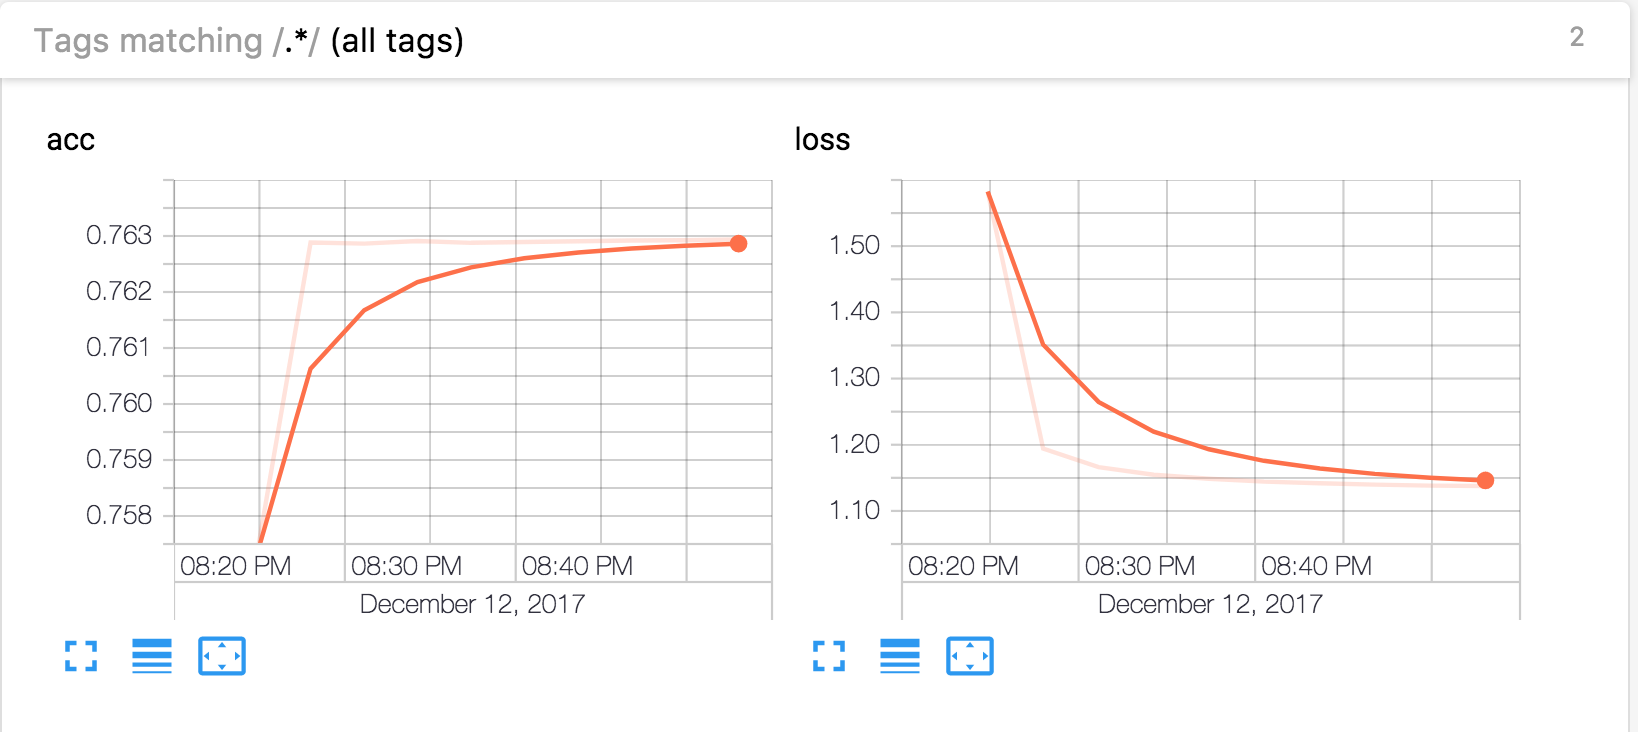

In [13]:
from IPython.display import Image
Image(filename='tensorboard.png',width=1000,height=800)

# Unidirectional LSTM Encoder Decoder With Attention

Define the parameters for your LSTM encoder decoder model with attention

reference: https://machinelearningmastery.com/encoder-decoder-attention-sequence-to-sequence-prediction-keras/

In [1]:
MAX_LEN = 200
VOCAB_SIZE = 10000
BATCH_SIZE = 128
LAYER_NUM = 1
HIDDEN_DIM = 128
NB_EPOCH = 25

You would've observed that the summaries are not yet perfect. This is because in encoder decoder architecture, only the final state of encoder is used to calculate the probabilities. We now move to a more general approach called attention based approach. In this, we take a weighted sum of all weights of encoder instead of just the last one. You are already provided an attention_decoder.py file with AttentionDecoder. Add this layer on top of your encoder and run the same experiment as before. For this part, you don't need to worry about return_probabilities argument to create_UniLSTMwithAttention function. Just pass it as an argument to your attention decoder layer. When return_probabilities is false, the attention decoder returns prediction model, which is what you need for this part of the assignment. When return_probabilities is true, the attention decoder returns the probability model, which you will be using later in the Analysis part of this assignment

In [3]:
# define model with Attention
from attention_decoder import AttentionDecoder
def create_UniLSTMwithAttention(X_vocab_len, X_max_len, y_vocab_len, y_max_len, hidden_size, num_layers, return_probabilities = False):
    model = Sequential()

    # Creating encoder network
    model.add(Embedding(X_vocab_len, hidden_size, input_length=X_max_len, mask_zero=True))
    model.add(LSTM(hidden_size))
    model.add(RepeatVector(y_max_len))

    # Creating decoder network, Attention Decoder
    model.add(AttentionDecoder(hidden_size, y_vocab_len))
    
    model.compile(loss='categorical_crossentropy',
            optimizer='rmsprop',
            metrics=['accuracy'])
    return model


In [4]:
print('[INFO] Loading data...')
X, X_vocab_len, X_word_to_ix, X_ix_to_word, y, y_vocab_len, y_word_to_ix, y_ix_to_word = load_data('data/train_article.txt', 'data/train_title.txt', MAX_LEN, VOCAB_SIZE)

# Finding the length of the longest sequence

X_max_len = max(max([len(sentence) for sentence in X]), max([len(sentence) for sentence in y]))
y_max_len = max(max([len(sentence) for sentence in X]), max([len(sentence) for sentence in y]))

# Padding zeros to make all sequences have a same length with the longest one
print('[INFO] Zero padding...')
X = pad_sequences(X, maxlen=X_max_len, dtype='int32', padding='post')
y = pad_sequences(y, maxlen=y_max_len, dtype='int32', padding='post')


# Creating the network model
print('[INFO] Compiling model...')
model = create_UniLSTMwithAttention(X_vocab_len, X_max_len, y_vocab_len, y_max_len, HIDDEN_DIM, LAYER_NUM)

[INFO] Loading data...
[INFO] Zero padding...
[INFO] Compiling model...


In [5]:
print(X.shape)
print(y.shape)
X_vocab_len


(50000, 32)
(50000, 32)


10002

# Train the Model
Train the model, as you did before, for the model without attention

In [7]:
from keras.callbacks import TensorBoard, ModelCheckpoint
#tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)
checkpoint = ModelCheckpoint('./weight/with_attention_weight_1.hdf5', save_weights_only=True,save_best_only=True,monitor='val_loss')
#callbacks_list = [tensorboard, checkpoint]

k_start = 1
for k in range(k_start, NB_EPOCH+1):
    # Shuffling the training data every epoch to avoid local minima
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    # Training 500 sequences at a time
    for i in range(0, len(X), 200):
        if i + 200 >= len(X):
            i_end = len(X)
        else:
            i_end = i + 200
        y_sequences = process_data(y[i:i_end], y_max_len, y_word_to_ix)

        print('[INFO] Training model: epoch {}th {}/{} samples'.format(k, i, len(X)))
        model.fit(X[i:i_end], y_sequences, batch_size=BATCH_SIZE, nb_epoch=1, validation_split=0.2, callbacks=[checkpoint])


[INFO] Training model: epoch 1th 0/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1


/usr/local/lib/python3.4/dist-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


160/160 [==============================] - 28s - loss: 9.2060 - acc: 0.1580 - val_loss: 9.1213 - val_acc: 0.7492
[INFO] Training model: epoch 1th 200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 6s - loss: 9.0468 - acc: 0.7590 - val_loss: 7.2572 - val_acc: 0.7547
[INFO] Training model: epoch 1th 400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 6s - loss: 6.8255 - acc: 0.7633 - val_loss: 4.0111 - val_acc: 0.7680
[INFO] Training model: epoch 1th 600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 7s - loss: 3.8629 - acc: 0.7629 - val_loss: 2.5982 - val_acc: 0.7742
[INFO] Training model: epoch 1th 800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 7s - loss: 2.5694 - acc: 0.7670 - val_loss: 2.1056 - val_acc: 0.7812
[INFO] Training

160/160 [==============================] - 4s - loss: 1.8314 - acc: 0.7758 - val_loss: 1.9255 - val_acc: 0.7703
[INFO] Training model: epoch 1th 15000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.9422 - acc: 0.7666 - val_loss: 1.7246 - val_acc: 0.7812
[INFO] Training model: epoch 1th 15200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.7915 - acc: 0.7793 - val_loss: 1.7479 - val_acc: 0.7891
[INFO] Training model: epoch 1th 15400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 7s - loss: 1.8675 - acc: 0.7744 - val_loss: 1.6792 - val_acc: 0.7914
[INFO] Training model: epoch 1th 15600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.8964 - acc: 0.7725 - val_loss: 2.0913 - val_acc: 0.7539
[INFO] T

160/160 [==============================] - 4s - loss: 1.8107 - acc: 0.7787 - val_loss: 1.7736 - val_acc: 0.7758
[INFO] Training model: epoch 1th 29800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.7889 - acc: 0.7809 - val_loss: 1.6921 - val_acc: 0.7945
[INFO] Training model: epoch 1th 30000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.7057 - acc: 0.7857 - val_loss: 1.7550 - val_acc: 0.7773
[INFO] Training model: epoch 1th 30200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.8067 - acc: 0.7789 - val_loss: 1.8185 - val_acc: 0.7672
[INFO] Training model: epoch 1th 30400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.7406 - acc: 0.7754 - val_loss: 1.6657 - val_acc: 0.7898
[INFO] T

160/160 [==============================] - 4s - loss: 1.7430 - acc: 0.7840 - val_loss: 1.6825 - val_acc: 0.7883
[INFO] Training model: epoch 1th 44600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.7401 - acc: 0.7816 - val_loss: 1.6887 - val_acc: 0.7867
[INFO] Training model: epoch 1th 44800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.7460 - acc: 0.7830 - val_loss: 1.7085 - val_acc: 0.7820
[INFO] Training model: epoch 1th 45000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.7892 - acc: 0.7754 - val_loss: 1.5820 - val_acc: 0.7992
[INFO] Training model: epoch 1th 45200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.7415 - acc: 0.7818 - val_loss: 1.8344 - val_acc: 0.7758
[INFO] T

160/160 [==============================] - 4s - loss: 1.7598 - acc: 0.7727 - val_loss: 1.7103 - val_acc: 0.7828
[INFO] Training model: epoch 2th 9400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.7199 - acc: 0.7811 - val_loss: 1.6126 - val_acc: 0.7922
[INFO] Training model: epoch 2th 9600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6550 - acc: 0.7861 - val_loss: 1.7904 - val_acc: 0.7750
[INFO] Training model: epoch 2th 9800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6937 - acc: 0.7814 - val_loss: 1.6258 - val_acc: 0.7883
[INFO] Training model: epoch 2th 10000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6406 - acc: 0.7887 - val_loss: 1.6606 - val_acc: 0.7883
[INFO] Trai

160/160 [==============================] - 4s - loss: 1.7453 - acc: 0.7822 - val_loss: 1.6276 - val_acc: 0.7891
[INFO] Training model: epoch 2th 24200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6813 - acc: 0.7836 - val_loss: 1.7158 - val_acc: 0.7922
[INFO] Training model: epoch 2th 24400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.7938 - acc: 0.7738 - val_loss: 1.6371 - val_acc: 0.7937
[INFO] Training model: epoch 2th 24600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6688 - acc: 0.7891 - val_loss: 1.8769 - val_acc: 0.7609
[INFO] Training model: epoch 2th 24800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6281 - acc: 0.7865 - val_loss: 1.7077 - val_acc: 0.7852
[INFO] T

160/160 [==============================] - 4s - loss: 1.6343 - acc: 0.7955 - val_loss: 1.7467 - val_acc: 0.7719
[INFO] Training model: epoch 2th 39000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.7200 - acc: 0.7793 - val_loss: 1.6900 - val_acc: 0.7844
[INFO] Training model: epoch 2th 39200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6451 - acc: 0.7922 - val_loss: 1.5235 - val_acc: 0.8055
[INFO] Training model: epoch 2th 39400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6222 - acc: 0.7887 - val_loss: 1.5912 - val_acc: 0.7984
[INFO] Training model: epoch 2th 39600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6962 - acc: 0.7887 - val_loss: 1.7148 - val_acc: 0.7828
[INFO] T

160/160 [==============================] - 4s - loss: 1.6521 - acc: 0.7836 - val_loss: 1.7213 - val_acc: 0.7734
[INFO] Training model: epoch 3th 3800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6862 - acc: 0.7830 - val_loss: 1.5982 - val_acc: 0.7937
[INFO] Training model: epoch 3th 4000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6988 - acc: 0.7816 - val_loss: 1.6632 - val_acc: 0.7867
[INFO] Training model: epoch 3th 4200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.7351 - acc: 0.7781 - val_loss: 1.5801 - val_acc: 0.7906
[INFO] Training model: epoch 3th 4400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.7693 - acc: 0.7715 - val_loss: 1.7192 - val_acc: 0.7734
[INFO] Train

160/160 [==============================] - 4s - loss: 1.6959 - acc: 0.7809 - val_loss: 1.8186 - val_acc: 0.7672
[INFO] Training model: epoch 3th 18600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6937 - acc: 0.7848 - val_loss: 1.8834 - val_acc: 0.7648
[INFO] Training model: epoch 3th 18800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.7082 - acc: 0.7787 - val_loss: 1.7895 - val_acc: 0.7734
[INFO] Training model: epoch 3th 19000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6668 - acc: 0.7844 - val_loss: 1.7729 - val_acc: 0.7711
[INFO] Training model: epoch 3th 19200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.7469 - acc: 0.7729 - val_loss: 1.7956 - val_acc: 0.7664
[INFO] T

160/160 [==============================] - 4s - loss: 1.6331 - acc: 0.7893 - val_loss: 1.6924 - val_acc: 0.7930
[INFO] Training model: epoch 3th 33400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5567 - acc: 0.7943 - val_loss: 1.6696 - val_acc: 0.7828
[INFO] Training model: epoch 3th 33600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5867 - acc: 0.7961 - val_loss: 1.5167 - val_acc: 0.8000
[INFO] Training model: epoch 3th 33800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.7102 - acc: 0.7734 - val_loss: 1.7522 - val_acc: 0.7656
[INFO] Training model: epoch 3th 34000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6067 - acc: 0.7936 - val_loss: 1.6072 - val_acc: 0.7828
[INFO] T

160/160 [==============================] - 4s - loss: 1.7427 - acc: 0.7783 - val_loss: 1.3844 - val_acc: 0.8227
[INFO] Training model: epoch 3th 48200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6370 - acc: 0.7875 - val_loss: 1.6843 - val_acc: 0.7875
[INFO] Training model: epoch 3th 48400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6169 - acc: 0.7904 - val_loss: 1.6726 - val_acc: 0.7859
[INFO] Training model: epoch 3th 48600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.7725 - acc: 0.7715 - val_loss: 1.5961 - val_acc: 0.7867
[INFO] Training model: epoch 3th 48800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6788 - acc: 0.7826 - val_loss: 1.4381 - val_acc: 0.8125
[INFO] T

160/160 [==============================] - 4s - loss: 1.6350 - acc: 0.7844 - val_loss: 1.6848 - val_acc: 0.7898
[INFO] Training model: epoch 4th 13000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6976 - acc: 0.7725 - val_loss: 1.6731 - val_acc: 0.7836
[INFO] Training model: epoch 4th 13200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6178 - acc: 0.7881 - val_loss: 1.6353 - val_acc: 0.7867
[INFO] Training model: epoch 4th 13400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.7027 - acc: 0.7750 - val_loss: 1.5969 - val_acc: 0.7805
[INFO] Training model: epoch 4th 13600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5873 - acc: 0.7887 - val_loss: 1.6682 - val_acc: 0.7891
[INFO] T

160/160 [==============================] - 4s - loss: 1.7195 - acc: 0.7758 - val_loss: 1.5195 - val_acc: 0.8047
[INFO] Training model: epoch 4th 27800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5525 - acc: 0.7994 - val_loss: 1.9171 - val_acc: 0.7500
[INFO] Training model: epoch 4th 28000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6398 - acc: 0.7801 - val_loss: 1.6871 - val_acc: 0.7797
[INFO] Training model: epoch 4th 28200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5515 - acc: 0.7934 - val_loss: 1.5156 - val_acc: 0.7945
[INFO] Training model: epoch 4th 28400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 6s - loss: 1.5934 - acc: 0.7883 - val_loss: 1.2961 - val_acc: 0.8227
[INFO] T

160/160 [==============================] - 4s - loss: 1.7413 - acc: 0.7682 - val_loss: 1.6062 - val_acc: 0.7922
[INFO] Training model: epoch 4th 42600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6668 - acc: 0.7818 - val_loss: 1.5613 - val_acc: 0.7898
[INFO] Training model: epoch 4th 42800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6564 - acc: 0.7820 - val_loss: 1.4981 - val_acc: 0.7992
[INFO] Training model: epoch 4th 43000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6470 - acc: 0.7828 - val_loss: 1.5831 - val_acc: 0.7945
[INFO] Training model: epoch 4th 43200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.7571 - acc: 0.7727 - val_loss: 1.6428 - val_acc: 0.7867
[INFO] T

160/160 [==============================] - 4s - loss: 1.7059 - acc: 0.7791 - val_loss: 1.5789 - val_acc: 0.7930
[INFO] Training model: epoch 5th 7400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5549 - acc: 0.7961 - val_loss: 1.5646 - val_acc: 0.7969
[INFO] Training model: epoch 5th 7600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5390 - acc: 0.7916 - val_loss: 1.6131 - val_acc: 0.7852
[INFO] Training model: epoch 5th 7800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5920 - acc: 0.7879 - val_loss: 1.5349 - val_acc: 0.7883
[INFO] Training model: epoch 5th 8000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5828 - acc: 0.7900 - val_loss: 1.5354 - val_acc: 0.7930
[INFO] Train

160/160 [==============================] - 4s - loss: 1.5515 - acc: 0.7951 - val_loss: 1.4848 - val_acc: 0.8008
[INFO] Training model: epoch 5th 22200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.7302 - acc: 0.7738 - val_loss: 1.5122 - val_acc: 0.7977
[INFO] Training model: epoch 5th 22400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5585 - acc: 0.7912 - val_loss: 1.5345 - val_acc: 0.8031
[INFO] Training model: epoch 5th 22600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5493 - acc: 0.7922 - val_loss: 1.6451 - val_acc: 0.7875
[INFO] Training model: epoch 5th 22800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6276 - acc: 0.7848 - val_loss: 1.6832 - val_acc: 0.7766
[INFO] T

160/160 [==============================] - 4s - loss: 1.6085 - acc: 0.7898 - val_loss: 1.4657 - val_acc: 0.8031
[INFO] Training model: epoch 5th 37000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5837 - acc: 0.7912 - val_loss: 1.6108 - val_acc: 0.7859
[INFO] Training model: epoch 5th 37200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5736 - acc: 0.7910 - val_loss: 1.4828 - val_acc: 0.8055
[INFO] Training model: epoch 5th 37400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5996 - acc: 0.7850 - val_loss: 1.6905 - val_acc: 0.7773
[INFO] Training model: epoch 5th 37600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6318 - acc: 0.7867 - val_loss: 1.5957 - val_acc: 0.7859
[INFO] T

160/160 [==============================] - 4s - loss: 1.6361 - acc: 0.7828 - val_loss: 1.6798 - val_acc: 0.7789
[INFO] Training model: epoch 6th 1800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5503 - acc: 0.7887 - val_loss: 1.4225 - val_acc: 0.8047
[INFO] Training model: epoch 6th 2000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5528 - acc: 0.7896 - val_loss: 1.5654 - val_acc: 0.7937
[INFO] Training model: epoch 6th 2200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6018 - acc: 0.7863 - val_loss: 1.5300 - val_acc: 0.7937
[INFO] Training model: epoch 6th 2400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6356 - acc: 0.7795 - val_loss: 1.5834 - val_acc: 0.7852
[INFO] Train

160/160 [==============================] - 4s - loss: 1.6459 - acc: 0.7770 - val_loss: 1.5739 - val_acc: 0.7984
[INFO] Training model: epoch 6th 16600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4472 - acc: 0.8047 - val_loss: 1.5945 - val_acc: 0.7820
[INFO] Training model: epoch 6th 16800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5167 - acc: 0.7979 - val_loss: 1.5928 - val_acc: 0.7898
[INFO] Training model: epoch 6th 17000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6769 - acc: 0.7748 - val_loss: 1.5210 - val_acc: 0.7961
[INFO] Training model: epoch 6th 17200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6276 - acc: 0.7857 - val_loss: 1.4929 - val_acc: 0.7898
[INFO] T

160/160 [==============================] - 4s - loss: 1.5765 - acc: 0.7826 - val_loss: 1.4855 - val_acc: 0.8117
[INFO] Training model: epoch 6th 31400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5733 - acc: 0.7924 - val_loss: 1.4635 - val_acc: 0.7977
[INFO] Training model: epoch 6th 31600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5885 - acc: 0.7869 - val_loss: 1.4906 - val_acc: 0.7953
[INFO] Training model: epoch 6th 31800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6074 - acc: 0.7881 - val_loss: 1.5878 - val_acc: 0.7875
[INFO] Training model: epoch 6th 32000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5610 - acc: 0.7896 - val_loss: 1.6498 - val_acc: 0.7828
[INFO] T

160/160 [==============================] - 4s - loss: 1.5332 - acc: 0.7928 - val_loss: 1.5857 - val_acc: 0.7867
[INFO] Training model: epoch 6th 46200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6729 - acc: 0.7807 - val_loss: 1.5011 - val_acc: 0.8008
[INFO] Training model: epoch 6th 46400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5422 - acc: 0.7955 - val_loss: 1.5005 - val_acc: 0.7984
[INFO] Training model: epoch 6th 46600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5388 - acc: 0.7980 - val_loss: 1.6540 - val_acc: 0.7812
[INFO] Training model: epoch 6th 46800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5624 - acc: 0.7914 - val_loss: 1.7347 - val_acc: 0.7789
[INFO] T

160/160 [==============================] - 4s - loss: 1.4904 - acc: 0.7994 - val_loss: 1.3881 - val_acc: 0.8141
[INFO] Training model: epoch 7th 11000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5138 - acc: 0.7930 - val_loss: 1.7292 - val_acc: 0.7672
[INFO] Training model: epoch 7th 11200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5157 - acc: 0.7979 - val_loss: 1.6677 - val_acc: 0.7766
[INFO] Training model: epoch 7th 11400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6513 - acc: 0.7803 - val_loss: 1.4733 - val_acc: 0.7969
[INFO] Training model: epoch 7th 11600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4989 - acc: 0.7967 - val_loss: 1.5649 - val_acc: 0.7898
[INFO] T

160/160 [==============================] - 4s - loss: 1.5857 - acc: 0.7887 - val_loss: 1.6322 - val_acc: 0.7844
[INFO] Training model: epoch 7th 25800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5776 - acc: 0.7883 - val_loss: 1.5634 - val_acc: 0.7875
[INFO] Training model: epoch 7th 26000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5146 - acc: 0.7932 - val_loss: 1.5140 - val_acc: 0.8023
[INFO] Training model: epoch 7th 26200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5372 - acc: 0.7951 - val_loss: 1.6883 - val_acc: 0.7789
[INFO] Training model: epoch 7th 26400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5920 - acc: 0.7867 - val_loss: 1.7832 - val_acc: 0.7719
[INFO] T

160/160 [==============================] - 4s - loss: 1.5777 - acc: 0.7887 - val_loss: 1.6694 - val_acc: 0.7789
[INFO] Training model: epoch 7th 40600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5813 - acc: 0.7893 - val_loss: 1.5539 - val_acc: 0.7937
[INFO] Training model: epoch 7th 40800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6435 - acc: 0.7834 - val_loss: 1.5477 - val_acc: 0.7797
[INFO] Training model: epoch 7th 41000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5509 - acc: 0.7943 - val_loss: 1.5531 - val_acc: 0.7945
[INFO] Training model: epoch 7th 41200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5328 - acc: 0.7961 - val_loss: 1.5864 - val_acc: 0.7891
[INFO] T

160/160 [==============================] - 4s - loss: 1.5052 - acc: 0.7912 - val_loss: 1.4065 - val_acc: 0.8055
[INFO] Training model: epoch 8th 5400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5149 - acc: 0.7973 - val_loss: 1.6093 - val_acc: 0.7805
[INFO] Training model: epoch 8th 5600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4645 - acc: 0.8039 - val_loss: 1.5441 - val_acc: 0.7961
[INFO] Training model: epoch 8th 5800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4825 - acc: 0.7977 - val_loss: 1.7808 - val_acc: 0.7680
[INFO] Training model: epoch 8th 6000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4830 - acc: 0.8012 - val_loss: 1.3491 - val_acc: 0.8148
[INFO] Train

160/160 [==============================] - 4s - loss: 1.5710 - acc: 0.7939 - val_loss: 1.7107 - val_acc: 0.7711
[INFO] Training model: epoch 8th 20200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5784 - acc: 0.7873 - val_loss: 1.6710 - val_acc: 0.7766
[INFO] Training model: epoch 8th 20400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5447 - acc: 0.7873 - val_loss: 1.6359 - val_acc: 0.7742
[INFO] Training model: epoch 8th 20600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4933 - acc: 0.7955 - val_loss: 1.4483 - val_acc: 0.8062
[INFO] Training model: epoch 8th 20800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5005 - acc: 0.7969 - val_loss: 1.5708 - val_acc: 0.7852
[INFO] T

160/160 [==============================] - 4s - loss: 1.4327 - acc: 0.8010 - val_loss: 1.5739 - val_acc: 0.7875
[INFO] Training model: epoch 8th 35000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5316 - acc: 0.7953 - val_loss: 1.5953 - val_acc: 0.7852
[INFO] Training model: epoch 8th 35200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5052 - acc: 0.7988 - val_loss: 1.4382 - val_acc: 0.8062
[INFO] Training model: epoch 8th 35400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6056 - acc: 0.7879 - val_loss: 1.5362 - val_acc: 0.7859
[INFO] Training model: epoch 8th 35600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5567 - acc: 0.7877 - val_loss: 1.5213 - val_acc: 0.7867
[INFO] T

160/160 [==============================] - 4s - loss: 1.4919 - acc: 0.7963 - val_loss: 1.5016 - val_acc: 0.7891
[INFO] Training model: epoch 8th 49800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4378 - acc: 0.7990 - val_loss: 1.4630 - val_acc: 0.8008
[INFO] Training model: epoch 9th 0/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5428 - acc: 0.7895 - val_loss: 1.3072 - val_acc: 0.8258
[INFO] Training model: epoch 9th 200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4885 - acc: 0.7969 - val_loss: 1.5160 - val_acc: 0.7953
[INFO] Training model: epoch 9th 400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4627 - acc: 0.8008 - val_loss: 1.4877 - val_acc: 0.7891
[INFO] Training 

160/160 [==============================] - 4s - loss: 1.5553 - acc: 0.7893 - val_loss: 1.4668 - val_acc: 0.7875
[INFO] Training model: epoch 9th 14600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4963 - acc: 0.7953 - val_loss: 1.4338 - val_acc: 0.7984
[INFO] Training model: epoch 9th 14800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5416 - acc: 0.7912 - val_loss: 1.2541 - val_acc: 0.8305
[INFO] Training model: epoch 9th 15000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5581 - acc: 0.7883 - val_loss: 1.5099 - val_acc: 0.7891
[INFO] Training model: epoch 9th 15200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5281 - acc: 0.7912 - val_loss: 1.5656 - val_acc: 0.7828
[INFO] T

160/160 [==============================] - 4s - loss: 1.5685 - acc: 0.7895 - val_loss: 1.3362 - val_acc: 0.8102
[INFO] Training model: epoch 9th 29400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5141 - acc: 0.7959 - val_loss: 1.5451 - val_acc: 0.7937
[INFO] Training model: epoch 9th 29600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5342 - acc: 0.7926 - val_loss: 1.6952 - val_acc: 0.7773
[INFO] Training model: epoch 9th 29800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5410 - acc: 0.7920 - val_loss: 1.5342 - val_acc: 0.7898
[INFO] Training model: epoch 9th 30000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6289 - acc: 0.7850 - val_loss: 1.7938 - val_acc: 0.7602
[INFO] T

160/160 [==============================] - 4s - loss: 1.6017 - acc: 0.7875 - val_loss: 1.5273 - val_acc: 0.7984
[INFO] Training model: epoch 9th 44200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5330 - acc: 0.7926 - val_loss: 1.5968 - val_acc: 0.7898
[INFO] Training model: epoch 9th 44400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6052 - acc: 0.7820 - val_loss: 1.4266 - val_acc: 0.8055
[INFO] Training model: epoch 9th 44600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5692 - acc: 0.7873 - val_loss: 1.5982 - val_acc: 0.7875
[INFO] Training model: epoch 9th 44800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5101 - acc: 0.7893 - val_loss: 1.5632 - val_acc: 0.7891
[INFO] T

160/160 [==============================] - 4s - loss: 1.5182 - acc: 0.7893 - val_loss: 1.5600 - val_acc: 0.7945
[INFO] Training model: epoch 10th 9000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5961 - acc: 0.7842 - val_loss: 1.3950 - val_acc: 0.8102
[INFO] Training model: epoch 10th 9200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3954 - acc: 0.8055 - val_loss: 1.4512 - val_acc: 0.8109
[INFO] Training model: epoch 10th 9400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6068 - acc: 0.7850 - val_loss: 1.4817 - val_acc: 0.7859
[INFO] Training model: epoch 10th 9600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5044 - acc: 0.7943 - val_loss: 1.5678 - val_acc: 0.7859
[INFO] T

160/160 [==============================] - 4s - loss: 1.4494 - acc: 0.8043 - val_loss: 1.4398 - val_acc: 0.8000
[INFO] Training model: epoch 10th 23800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4882 - acc: 0.7906 - val_loss: 1.4720 - val_acc: 0.7969
[INFO] Training model: epoch 10th 24000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4711 - acc: 0.7996 - val_loss: 1.4229 - val_acc: 0.8031
[INFO] Training model: epoch 10th 24200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4809 - acc: 0.7963 - val_loss: 1.6441 - val_acc: 0.7742
[INFO] Training model: epoch 10th 24400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5829 - acc: 0.7871 - val_loss: 1.5263 - val_acc: 0.7883
[INF

160/160 [==============================] - 4s - loss: 1.4481 - acc: 0.8008 - val_loss: 1.5432 - val_acc: 0.7883
[INFO] Training model: epoch 10th 38600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5205 - acc: 0.7918 - val_loss: 1.5099 - val_acc: 0.8000
[INFO] Training model: epoch 10th 38800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4377 - acc: 0.8055 - val_loss: 1.4194 - val_acc: 0.8023
[INFO] Training model: epoch 10th 39000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5062 - acc: 0.7938 - val_loss: 1.3582 - val_acc: 0.8117
[INFO] Training model: epoch 10th 39200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5448 - acc: 0.7934 - val_loss: 1.5103 - val_acc: 0.8047
[INF

160/160 [==============================] - 4s - loss: 1.5024 - acc: 0.7932 - val_loss: 1.4932 - val_acc: 0.8078
[INFO] Training model: epoch 11th 3400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4992 - acc: 0.8029 - val_loss: 1.2787 - val_acc: 0.8203
[INFO] Training model: epoch 11th 3600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5282 - acc: 0.7869 - val_loss: 1.4103 - val_acc: 0.7945
[INFO] Training model: epoch 11th 3800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4889 - acc: 0.7936 - val_loss: 1.4329 - val_acc: 0.8039
[INFO] Training model: epoch 11th 4000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4583 - acc: 0.7947 - val_loss: 1.4941 - val_acc: 0.7836
[INFO] T

160/160 [==============================] - 4s - loss: 1.4489 - acc: 0.7982 - val_loss: 1.5749 - val_acc: 0.7859
[INFO] Training model: epoch 11th 18200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4876 - acc: 0.7928 - val_loss: 1.5545 - val_acc: 0.7906
[INFO] Training model: epoch 11th 18400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4377 - acc: 0.8041 - val_loss: 1.4079 - val_acc: 0.8039
[INFO] Training model: epoch 11th 18600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4245 - acc: 0.8000 - val_loss: 1.4477 - val_acc: 0.8023
[INFO] Training model: epoch 11th 18800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5420 - acc: 0.7891 - val_loss: 1.6822 - val_acc: 0.7664
[INF

160/160 [==============================] - 4s - loss: 1.5132 - acc: 0.7945 - val_loss: 1.6556 - val_acc: 0.7844
[INFO] Training model: epoch 11th 33000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5085 - acc: 0.7918 - val_loss: 1.5289 - val_acc: 0.7859
[INFO] Training model: epoch 11th 33200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4989 - acc: 0.7945 - val_loss: 1.5428 - val_acc: 0.7883
[INFO] Training model: epoch 11th 33400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5124 - acc: 0.7852 - val_loss: 1.5329 - val_acc: 0.7922
[INFO] Training model: epoch 11th 33600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5305 - acc: 0.7891 - val_loss: 1.4745 - val_acc: 0.7961
[INF

160/160 [==============================] - 4s - loss: 1.5442 - acc: 0.7881 - val_loss: 1.3712 - val_acc: 0.8109
[INFO] Training model: epoch 11th 47800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5026 - acc: 0.7941 - val_loss: 1.4059 - val_acc: 0.8000
[INFO] Training model: epoch 11th 48000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5753 - acc: 0.7883 - val_loss: 1.5080 - val_acc: 0.7937
[INFO] Training model: epoch 11th 48200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5203 - acc: 0.7895 - val_loss: 1.4243 - val_acc: 0.7961
[INFO] Training model: epoch 11th 48400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3571 - acc: 0.8094 - val_loss: 1.3601 - val_acc: 0.8094
[INF

160/160 [==============================] - 4s - loss: 1.4452 - acc: 0.7990 - val_loss: 1.6497 - val_acc: 0.7727
[INFO] Training model: epoch 12th 12600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5242 - acc: 0.7910 - val_loss: 1.4181 - val_acc: 0.8086
[INFO] Training model: epoch 12th 12800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4129 - acc: 0.8037 - val_loss: 1.3923 - val_acc: 0.7930
[INFO] Training model: epoch 12th 13000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4679 - acc: 0.8010 - val_loss: 1.4072 - val_acc: 0.8023
[INFO] Training model: epoch 12th 13200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5170 - acc: 0.7881 - val_loss: 1.4887 - val_acc: 0.7984
[INF

160/160 [==============================] - 4s - loss: 1.5623 - acc: 0.7873 - val_loss: 1.4715 - val_acc: 0.8000
[INFO] Training model: epoch 12th 27400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5530 - acc: 0.7832 - val_loss: 1.3292 - val_acc: 0.8094
[INFO] Training model: epoch 12th 27600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4469 - acc: 0.7992 - val_loss: 1.4219 - val_acc: 0.8078
[INFO] Training model: epoch 12th 27800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5228 - acc: 0.7861 - val_loss: 1.4364 - val_acc: 0.7992
[INFO] Training model: epoch 12th 28000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4770 - acc: 0.7953 - val_loss: 1.5977 - val_acc: 0.7844
[INF

160/160 [==============================] - 4s - loss: 1.4955 - acc: 0.7926 - val_loss: 1.5075 - val_acc: 0.8000
[INFO] Training model: epoch 12th 42200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5435 - acc: 0.7908 - val_loss: 1.4253 - val_acc: 0.7945
[INFO] Training model: epoch 12th 42400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5302 - acc: 0.7912 - val_loss: 1.3553 - val_acc: 0.8148
[INFO] Training model: epoch 12th 42600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4229 - acc: 0.8016 - val_loss: 1.4788 - val_acc: 0.7992
[INFO] Training model: epoch 12th 42800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4378 - acc: 0.7994 - val_loss: 1.6039 - val_acc: 0.7781
[INF

160/160 [==============================] - 4s - loss: 1.4014 - acc: 0.8064 - val_loss: 1.6378 - val_acc: 0.7930
[INFO] Training model: epoch 13th 7000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4783 - acc: 0.7936 - val_loss: 1.2498 - val_acc: 0.8148
[INFO] Training model: epoch 13th 7200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3831 - acc: 0.8039 - val_loss: 1.4015 - val_acc: 0.8047
[INFO] Training model: epoch 13th 7400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4355 - acc: 0.8027 - val_loss: 1.5257 - val_acc: 0.7820
[INFO] Training model: epoch 13th 7600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5083 - acc: 0.7885 - val_loss: 1.6053 - val_acc: 0.7719
[INFO] T

160/160 [==============================] - 4s - loss: 1.4940 - acc: 0.7906 - val_loss: 1.4760 - val_acc: 0.7937
[INFO] Training model: epoch 13th 21800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4210 - acc: 0.8018 - val_loss: 1.6710 - val_acc: 0.7773
[INFO] Training model: epoch 13th 22000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4544 - acc: 0.7986 - val_loss: 1.4656 - val_acc: 0.8023
[INFO] Training model: epoch 13th 22200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5011 - acc: 0.7957 - val_loss: 1.4266 - val_acc: 0.8023
[INFO] Training model: epoch 13th 22400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4677 - acc: 0.7938 - val_loss: 1.4882 - val_acc: 0.7906
[INF

160/160 [==============================] - 4s - loss: 1.4027 - acc: 0.8049 - val_loss: 1.5092 - val_acc: 0.7922
[INFO] Training model: epoch 13th 36600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5538 - acc: 0.7855 - val_loss: 1.4098 - val_acc: 0.8055
[INFO] Training model: epoch 13th 36800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4822 - acc: 0.7955 - val_loss: 1.5673 - val_acc: 0.7828
[INFO] Training model: epoch 13th 37000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4174 - acc: 0.7922 - val_loss: 1.4472 - val_acc: 0.7953
[INFO] Training model: epoch 13th 37200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4943 - acc: 0.7932 - val_loss: 1.5684 - val_acc: 0.7789
[INF

160/160 [==============================] - 4s - loss: 1.5279 - acc: 0.7807 - val_loss: 1.4159 - val_acc: 0.8000
[INFO] Training model: epoch 14th 1400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4970 - acc: 0.7906 - val_loss: 1.5729 - val_acc: 0.7844
[INFO] Training model: epoch 14th 1600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3975 - acc: 0.8031 - val_loss: 1.6114 - val_acc: 0.7695
[INFO] Training model: epoch 14th 1800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4231 - acc: 0.7986 - val_loss: 1.6670 - val_acc: 0.7641
[INFO] Training model: epoch 14th 2000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4124 - acc: 0.7980 - val_loss: 1.5171 - val_acc: 0.7883
[INFO] T

160/160 [==============================] - 4s - loss: 1.4456 - acc: 0.8031 - val_loss: 1.4247 - val_acc: 0.7969
[INFO] Training model: epoch 14th 16200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4679 - acc: 0.7941 - val_loss: 1.5135 - val_acc: 0.7883
[INFO] Training model: epoch 14th 16400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4729 - acc: 0.7953 - val_loss: 1.3254 - val_acc: 0.8164
[INFO] Training model: epoch 14th 16600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4663 - acc: 0.7930 - val_loss: 1.2696 - val_acc: 0.8156
[INFO] Training model: epoch 14th 16800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3512 - acc: 0.8072 - val_loss: 1.3666 - val_acc: 0.8008
[INF

160/160 [==============================] - 4s - loss: 1.3980 - acc: 0.8029 - val_loss: 1.4925 - val_acc: 0.7906
[INFO] Training model: epoch 14th 31000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5066 - acc: 0.7914 - val_loss: 1.4278 - val_acc: 0.7977
[INFO] Training model: epoch 14th 31200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4054 - acc: 0.8053 - val_loss: 1.4181 - val_acc: 0.8008
[INFO] Training model: epoch 14th 31400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4309 - acc: 0.7996 - val_loss: 1.4505 - val_acc: 0.7992
[INFO] Training model: epoch 14th 31600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4696 - acc: 0.7930 - val_loss: 1.4058 - val_acc: 0.8039
[INF

160/160 [==============================] - 4s - loss: 1.4933 - acc: 0.7926 - val_loss: 1.6247 - val_acc: 0.7656
[INFO] Training model: epoch 14th 45800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5032 - acc: 0.7906 - val_loss: 1.3640 - val_acc: 0.7977
[INFO] Training model: epoch 14th 46000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4048 - acc: 0.8045 - val_loss: 1.6764 - val_acc: 0.7695
[INFO] Training model: epoch 14th 46200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4056 - acc: 0.8027 - val_loss: 1.5719 - val_acc: 0.7820
[INFO] Training model: epoch 14th 46400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3775 - acc: 0.8068 - val_loss: 1.2473 - val_acc: 0.8211
[INF

160/160 [==============================] - 4s - loss: 1.3900 - acc: 0.8063 - val_loss: 1.3743 - val_acc: 0.7984
[INFO] Training model: epoch 15th 10600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3682 - acc: 0.8012 - val_loss: 1.3477 - val_acc: 0.8094
[INFO] Training model: epoch 15th 10800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4967 - acc: 0.7898 - val_loss: 1.4493 - val_acc: 0.7836
[INFO] Training model: epoch 15th 11000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3711 - acc: 0.8076 - val_loss: 1.2909 - val_acc: 0.8148
[INFO] Training model: epoch 15th 11200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3739 - acc: 0.8033 - val_loss: 1.4931 - val_acc: 0.7922
[INF

160/160 [==============================] - 4s - loss: 1.3863 - acc: 0.8039 - val_loss: 1.6023 - val_acc: 0.7820
[INFO] Training model: epoch 15th 25400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4009 - acc: 0.8027 - val_loss: 1.4801 - val_acc: 0.7977
[INFO] Training model: epoch 15th 25600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4509 - acc: 0.7973 - val_loss: 1.2820 - val_acc: 0.8125
[INFO] Training model: epoch 15th 25800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4173 - acc: 0.8020 - val_loss: 1.4127 - val_acc: 0.8016
[INFO] Training model: epoch 15th 26000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4663 - acc: 0.7939 - val_loss: 1.4826 - val_acc: 0.7977
[INF

160/160 [==============================] - 4s - loss: 1.4372 - acc: 0.7959 - val_loss: 1.6618 - val_acc: 0.7617
[INFO] Training model: epoch 15th 40200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4522 - acc: 0.7939 - val_loss: 1.4697 - val_acc: 0.8070
[INFO] Training model: epoch 15th 40400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4872 - acc: 0.7926 - val_loss: 1.4224 - val_acc: 0.8070
[INFO] Training model: epoch 15th 40600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4763 - acc: 0.7920 - val_loss: 1.4137 - val_acc: 0.7992
[INFO] Training model: epoch 15th 40800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5162 - acc: 0.7914 - val_loss: 1.4243 - val_acc: 0.8023
[INF

160/160 [==============================] - 4s - loss: 1.4638 - acc: 0.7918 - val_loss: 1.3797 - val_acc: 0.8023
[INFO] Training model: epoch 16th 5000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4100 - acc: 0.7980 - val_loss: 1.4101 - val_acc: 0.7961
[INFO] Training model: epoch 16th 5200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4843 - acc: 0.7938 - val_loss: 1.5077 - val_acc: 0.7805
[INFO] Training model: epoch 16th 5400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3562 - acc: 0.8016 - val_loss: 1.2701 - val_acc: 0.8078
[INFO] Training model: epoch 16th 5600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4746 - acc: 0.7906 - val_loss: 1.3193 - val_acc: 0.8062
[INFO] T

160/160 [==============================] - 4s - loss: 1.4427 - acc: 0.7936 - val_loss: 1.3015 - val_acc: 0.8195
[INFO] Training model: epoch 16th 19800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4593 - acc: 0.7932 - val_loss: 1.5671 - val_acc: 0.7734
[INFO] Training model: epoch 16th 20000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3832 - acc: 0.8074 - val_loss: 1.4494 - val_acc: 0.7961
[INFO] Training model: epoch 16th 20200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4790 - acc: 0.7949 - val_loss: 1.4095 - val_acc: 0.8133
[INFO] Training model: epoch 16th 20400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4957 - acc: 0.7881 - val_loss: 1.3661 - val_acc: 0.7984
[INF

160/160 [==============================] - 4s - loss: 1.4577 - acc: 0.7984 - val_loss: 1.4254 - val_acc: 0.8062
[INFO] Training model: epoch 16th 34600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4525 - acc: 0.7977 - val_loss: 1.5433 - val_acc: 0.7797
[INFO] Training model: epoch 16th 34800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4583 - acc: 0.7949 - val_loss: 1.3310 - val_acc: 0.8086
[INFO] Training model: epoch 16th 35000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4206 - acc: 0.8021 - val_loss: 1.5389 - val_acc: 0.7852
[INFO] Training model: epoch 16th 35200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3172 - acc: 0.8043 - val_loss: 1.4431 - val_acc: 0.8039
[INF

160/160 [==============================] - 4s - loss: 1.3647 - acc: 0.8066 - val_loss: 1.4431 - val_acc: 0.7945
[INFO] Training model: epoch 16th 49400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4698 - acc: 0.7967 - val_loss: 1.5275 - val_acc: 0.7898
[INFO] Training model: epoch 16th 49600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4314 - acc: 0.7955 - val_loss: 1.3376 - val_acc: 0.8055
[INFO] Training model: epoch 16th 49800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3222 - acc: 0.8105 - val_loss: 1.3508 - val_acc: 0.8156
[INFO] Training model: epoch 17th 0/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3657 - acc: 0.8086 - val_loss: 1.5270 - val_acc: 0.7805
[INFO] T

160/160 [==============================] - 4s - loss: 1.4637 - acc: 0.7959 - val_loss: 1.2411 - val_acc: 0.8094
[INFO] Training model: epoch 17th 14200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5220 - acc: 0.7871 - val_loss: 1.6401 - val_acc: 0.7664
[INFO] Training model: epoch 17th 14400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4400 - acc: 0.7959 - val_loss: 1.5497 - val_acc: 0.7828
[INFO] Training model: epoch 17th 14600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3515 - acc: 0.8021 - val_loss: 1.3688 - val_acc: 0.8047
[INFO] Training model: epoch 17th 14800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3765 - acc: 0.8043 - val_loss: 1.3731 - val_acc: 0.8047
[INF

160/160 [==============================] - 4s - loss: 1.3590 - acc: 0.8018 - val_loss: 1.3472 - val_acc: 0.8195
[INFO] Training model: epoch 17th 29000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5351 - acc: 0.7879 - val_loss: 1.3910 - val_acc: 0.7914
[INFO] Training model: epoch 17th 29200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4153 - acc: 0.7965 - val_loss: 1.2688 - val_acc: 0.8055
[INFO] Training model: epoch 17th 29400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4515 - acc: 0.7945 - val_loss: 1.5866 - val_acc: 0.7805
[INFO] Training model: epoch 17th 29600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4956 - acc: 0.7885 - val_loss: 1.5737 - val_acc: 0.7828
[INF

160/160 [==============================] - 4s - loss: 1.3560 - acc: 0.8035 - val_loss: 1.4385 - val_acc: 0.8023
[INFO] Training model: epoch 17th 43800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4421 - acc: 0.7969 - val_loss: 1.6845 - val_acc: 0.7812
[INFO] Training model: epoch 17th 44000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4568 - acc: 0.7908 - val_loss: 1.4378 - val_acc: 0.7961
[INFO] Training model: epoch 17th 44200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4711 - acc: 0.7914 - val_loss: 1.3704 - val_acc: 0.8023
[INFO] Training model: epoch 17th 44400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3697 - acc: 0.8055 - val_loss: 1.3326 - val_acc: 0.8156
[INF

160/160 [==============================] - 4s - loss: 1.3855 - acc: 0.8027 - val_loss: 1.3403 - val_acc: 0.8023
[INFO] Training model: epoch 18th 8600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4147 - acc: 0.8002 - val_loss: 1.1753 - val_acc: 0.8313
[INFO] Training model: epoch 18th 8800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3952 - acc: 0.8014 - val_loss: 1.3177 - val_acc: 0.8141
[INFO] Training model: epoch 18th 9000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3936 - acc: 0.7984 - val_loss: 1.3315 - val_acc: 0.8164
[INFO] Training model: epoch 18th 9200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3646 - acc: 0.8063 - val_loss: 1.4541 - val_acc: 0.7820
[INFO] T

160/160 [==============================] - 4s - loss: 1.4659 - acc: 0.7943 - val_loss: 1.4898 - val_acc: 0.7867
[INFO] Training model: epoch 18th 23400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3818 - acc: 0.8027 - val_loss: 1.3790 - val_acc: 0.8141
[INFO] Training model: epoch 18th 23600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4731 - acc: 0.7904 - val_loss: 1.7115 - val_acc: 0.7641
[INFO] Training model: epoch 18th 23800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3600 - acc: 0.8059 - val_loss: 1.3982 - val_acc: 0.8047
[INFO] Training model: epoch 18th 24000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4422 - acc: 0.7912 - val_loss: 1.4161 - val_acc: 0.8008
[INF

160/160 [==============================] - 4s - loss: 1.3501 - acc: 0.8063 - val_loss: 1.5848 - val_acc: 0.7875
[INFO] Training model: epoch 18th 38200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4487 - acc: 0.7873 - val_loss: 1.4829 - val_acc: 0.7898
[INFO] Training model: epoch 18th 38400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4564 - acc: 0.7988 - val_loss: 1.3393 - val_acc: 0.8062
[INFO] Training model: epoch 18th 38600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4216 - acc: 0.7979 - val_loss: 1.3762 - val_acc: 0.8008
[INFO] Training model: epoch 18th 38800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4279 - acc: 0.7986 - val_loss: 1.4889 - val_acc: 0.7883
[INF

160/160 [==============================] - 4s - loss: 1.3252 - acc: 0.8080 - val_loss: 1.2764 - val_acc: 0.7945
[INFO] Training model: epoch 19th 3000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4353 - acc: 0.7914 - val_loss: 1.4504 - val_acc: 0.7859
[INFO] Training model: epoch 19th 3200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3714 - acc: 0.8045 - val_loss: 1.1782 - val_acc: 0.8227
[INFO] Training model: epoch 19th 3400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3397 - acc: 0.8082 - val_loss: 1.3253 - val_acc: 0.8078
[INFO] Training model: epoch 19th 3600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4185 - acc: 0.7928 - val_loss: 1.4813 - val_acc: 0.7836
[INFO] T

160/160 [==============================] - 4s - loss: 1.3826 - acc: 0.7971 - val_loss: 1.3068 - val_acc: 0.8031
[INFO] Training model: epoch 19th 17800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4536 - acc: 0.7900 - val_loss: 1.3500 - val_acc: 0.8047
[INFO] Training model: epoch 19th 18000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3691 - acc: 0.8045 - val_loss: 1.4208 - val_acc: 0.7953
[INFO] Training model: epoch 19th 18200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4405 - acc: 0.7926 - val_loss: 1.3469 - val_acc: 0.8016
[INFO] Training model: epoch 19th 18400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4261 - acc: 0.7977 - val_loss: 1.2833 - val_acc: 0.8148
[INF

160/160 [==============================] - 4s - loss: 1.4815 - acc: 0.7881 - val_loss: 1.4499 - val_acc: 0.8031
[INFO] Training model: epoch 19th 32600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5184 - acc: 0.7828 - val_loss: 1.3558 - val_acc: 0.8070
[INFO] Training model: epoch 19th 32800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4159 - acc: 0.7988 - val_loss: 1.3659 - val_acc: 0.8109
[INFO] Training model: epoch 19th 33000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4735 - acc: 0.7924 - val_loss: 1.2881 - val_acc: 0.8109
[INFO] Training model: epoch 19th 33200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3455 - acc: 0.8092 - val_loss: 1.4769 - val_acc: 0.7945
[INF

160/160 [==============================] - 4s - loss: 1.3679 - acc: 0.8049 - val_loss: 1.3908 - val_acc: 0.8055
[INFO] Training model: epoch 19th 47400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3755 - acc: 0.8045 - val_loss: 1.4342 - val_acc: 0.7945
[INFO] Training model: epoch 19th 47600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3913 - acc: 0.8020 - val_loss: 1.4322 - val_acc: 0.7961
[INFO] Training model: epoch 19th 47800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3743 - acc: 0.8041 - val_loss: 1.3939 - val_acc: 0.7930
[INFO] Training model: epoch 19th 48000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3531 - acc: 0.8100 - val_loss: 1.5516 - val_acc: 0.7797
[INF

160/160 [==============================] - 4s - loss: 1.3576 - acc: 0.8031 - val_loss: 1.4242 - val_acc: 0.7961
[INFO] Training model: epoch 20th 12200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3507 - acc: 0.8061 - val_loss: 1.2868 - val_acc: 0.8180
[INFO] Training model: epoch 20th 12400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3398 - acc: 0.8082 - val_loss: 1.4706 - val_acc: 0.7937
[INFO] Training model: epoch 20th 12600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3511 - acc: 0.8041 - val_loss: 1.1921 - val_acc: 0.8219
[INFO] Training model: epoch 20th 12800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3348 - acc: 0.8018 - val_loss: 1.3480 - val_acc: 0.8062
[INF

160/160 [==============================] - 4s - loss: 1.3245 - acc: 0.8012 - val_loss: 1.3889 - val_acc: 0.7945
[INFO] Training model: epoch 20th 27000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3586 - acc: 0.8025 - val_loss: 1.2652 - val_acc: 0.8039
[INFO] Training model: epoch 20th 27200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3235 - acc: 0.8059 - val_loss: 1.3759 - val_acc: 0.7945
[INFO] Training model: epoch 20th 27400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3416 - acc: 0.8031 - val_loss: 1.2889 - val_acc: 0.8062
[INFO] Training model: epoch 20th 27600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3513 - acc: 0.8014 - val_loss: 1.5176 - val_acc: 0.7844
[INF

160/160 [==============================] - 4s - loss: 1.3670 - acc: 0.8055 - val_loss: 1.3986 - val_acc: 0.7969
[INFO] Training model: epoch 20th 41800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4206 - acc: 0.8023 - val_loss: 1.1035 - val_acc: 0.8438
[INFO] Training model: epoch 20th 42000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3626 - acc: 0.8053 - val_loss: 1.3876 - val_acc: 0.7992
[INFO] Training model: epoch 20th 42200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4317 - acc: 0.7973 - val_loss: 1.6170 - val_acc: 0.7742
[INFO] Training model: epoch 20th 42400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3969 - acc: 0.7949 - val_loss: 1.3247 - val_acc: 0.8094
[INF

160/160 [==============================] - 4s - loss: 1.3438 - acc: 0.8090 - val_loss: 1.2159 - val_acc: 0.8227
[INFO] Training model: epoch 21th 6600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3688 - acc: 0.8045 - val_loss: 1.4248 - val_acc: 0.8008
[INFO] Training model: epoch 21th 6800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3657 - acc: 0.7967 - val_loss: 1.5587 - val_acc: 0.7750
[INFO] Training model: epoch 21th 7000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3494 - acc: 0.8004 - val_loss: 1.2080 - val_acc: 0.8352
[INFO] Training model: epoch 21th 7200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4154 - acc: 0.7941 - val_loss: 1.4198 - val_acc: 0.7977
[INFO] T

160/160 [==============================] - 4s - loss: 1.3296 - acc: 0.8109 - val_loss: 1.5085 - val_acc: 0.7797
[INFO] Training model: epoch 21th 21400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4403 - acc: 0.7959 - val_loss: 1.2140 - val_acc: 0.8219
[INFO] Training model: epoch 21th 21600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4907 - acc: 0.7938 - val_loss: 1.4714 - val_acc: 0.7789
[INFO] Training model: epoch 21th 21800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4276 - acc: 0.7922 - val_loss: 1.0832 - val_acc: 0.8344
[INFO] Training model: epoch 21th 22000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3445 - acc: 0.8074 - val_loss: 1.1880 - val_acc: 0.8125
[INF

160/160 [==============================] - 4s - loss: 1.3066 - acc: 0.8098 - val_loss: 1.2546 - val_acc: 0.8062
[INFO] Training model: epoch 21th 36200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3485 - acc: 0.8039 - val_loss: 1.1935 - val_acc: 0.8164
[INFO] Training model: epoch 21th 36400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3971 - acc: 0.7984 - val_loss: 1.3629 - val_acc: 0.7961
[INFO] Training model: epoch 21th 36600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4149 - acc: 0.7959 - val_loss: 1.4628 - val_acc: 0.7992
[INFO] Training model: epoch 21th 36800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3645 - acc: 0.8010 - val_loss: 1.4297 - val_acc: 0.8000
[INF

160/160 [==============================] - 4s - loss: 1.1988 - acc: 0.8232 - val_loss: 1.3376 - val_acc: 0.8023
[INFO] Training model: epoch 22th 1000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3324 - acc: 0.8057 - val_loss: 1.3795 - val_acc: 0.7961
[INFO] Training model: epoch 22th 1200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4248 - acc: 0.7934 - val_loss: 1.2745 - val_acc: 0.8148
[INFO] Training model: epoch 22th 1400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3457 - acc: 0.8039 - val_loss: 1.2243 - val_acc: 0.8211
[INFO] Training model: epoch 22th 1600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3914 - acc: 0.7967 - val_loss: 1.3178 - val_acc: 0.8094
[INFO] T

160/160 [==============================] - 4s - loss: 1.3715 - acc: 0.7979 - val_loss: 1.3821 - val_acc: 0.7984
[INFO] Training model: epoch 22th 15800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.2915 - acc: 0.8078 - val_loss: 1.2710 - val_acc: 0.8148
[INFO] Training model: epoch 22th 16000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3613 - acc: 0.8049 - val_loss: 1.2973 - val_acc: 0.8109
[INFO] Training model: epoch 22th 16200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.2622 - acc: 0.8102 - val_loss: 1.5085 - val_acc: 0.7812
[INFO] Training model: epoch 22th 16400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4388 - acc: 0.7947 - val_loss: 1.4737 - val_acc: 0.7875
[INF

160/160 [==============================] - 4s - loss: 1.3592 - acc: 0.8000 - val_loss: 1.3020 - val_acc: 0.8039
[INFO] Training model: epoch 22th 30600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3628 - acc: 0.8041 - val_loss: 1.4634 - val_acc: 0.7961
[INFO] Training model: epoch 22th 30800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3823 - acc: 0.8012 - val_loss: 1.3343 - val_acc: 0.8078
[INFO] Training model: epoch 22th 31000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4050 - acc: 0.7975 - val_loss: 1.4501 - val_acc: 0.7875
[INFO] Training model: epoch 22th 31200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3260 - acc: 0.8051 - val_loss: 1.2359 - val_acc: 0.8164
[INF

160/160 [==============================] - 4s - loss: 1.4231 - acc: 0.7969 - val_loss: 1.3417 - val_acc: 0.8109
[INFO] Training model: epoch 22th 45400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4009 - acc: 0.8006 - val_loss: 1.4357 - val_acc: 0.7875
[INFO] Training model: epoch 22th 45600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3774 - acc: 0.8021 - val_loss: 1.5031 - val_acc: 0.7875
[INFO] Training model: epoch 22th 45800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4044 - acc: 0.7975 - val_loss: 1.3090 - val_acc: 0.8047
[INFO] Training model: epoch 22th 46000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4535 - acc: 0.7914 - val_loss: 1.3943 - val_acc: 0.8039
[INF

160/160 [==============================] - 4s - loss: 1.3210 - acc: 0.8094 - val_loss: 1.3588 - val_acc: 0.8039
[INFO] Training model: epoch 23th 10200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3293 - acc: 0.8008 - val_loss: 1.3177 - val_acc: 0.8016
[INFO] Training model: epoch 23th 10400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4331 - acc: 0.7926 - val_loss: 1.2611 - val_acc: 0.8086
[INFO] Training model: epoch 23th 10600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3638 - acc: 0.8014 - val_loss: 1.3446 - val_acc: 0.8023
[INFO] Training model: epoch 23th 10800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3938 - acc: 0.8021 - val_loss: 1.1312 - val_acc: 0.8359
[INF

160/160 [==============================] - 4s - loss: 1.3715 - acc: 0.7990 - val_loss: 1.3010 - val_acc: 0.8039
[INFO] Training model: epoch 23th 25000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4185 - acc: 0.7912 - val_loss: 1.3921 - val_acc: 0.8070
[INFO] Training model: epoch 23th 25200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4174 - acc: 0.7934 - val_loss: 1.5005 - val_acc: 0.7930
[INFO] Training model: epoch 23th 25400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4077 - acc: 0.7998 - val_loss: 1.2181 - val_acc: 0.8211
[INFO] Training model: epoch 23th 25600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3319 - acc: 0.8086 - val_loss: 1.2962 - val_acc: 0.8195
[INF

160/160 [==============================] - 4s - loss: 1.3629 - acc: 0.8037 - val_loss: 1.4028 - val_acc: 0.7969
[INFO] Training model: epoch 23th 39800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4523 - acc: 0.7918 - val_loss: 1.4071 - val_acc: 0.8008
[INFO] Training model: epoch 23th 40000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4109 - acc: 0.7951 - val_loss: 1.1576 - val_acc: 0.8172
[INFO] Training model: epoch 23th 40200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4119 - acc: 0.7963 - val_loss: 1.3040 - val_acc: 0.8055
[INFO] Training model: epoch 23th 40400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3201 - acc: 0.8041 - val_loss: 1.2855 - val_acc: 0.8047
[INF

160/160 [==============================] - 4s - loss: 1.3115 - acc: 0.8057 - val_loss: 1.0746 - val_acc: 0.8336
[INFO] Training model: epoch 24th 4600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3320 - acc: 0.8021 - val_loss: 1.2383 - val_acc: 0.8219
[INFO] Training model: epoch 24th 4800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4028 - acc: 0.7992 - val_loss: 1.2073 - val_acc: 0.8164
[INFO] Training model: epoch 24th 5000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3204 - acc: 0.8037 - val_loss: 1.2332 - val_acc: 0.8164
[INFO] Training model: epoch 24th 5200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3876 - acc: 0.7887 - val_loss: 1.4579 - val_acc: 0.7937
[INFO] T

160/160 [==============================] - 4s - loss: 1.3740 - acc: 0.7992 - val_loss: 1.4570 - val_acc: 0.7898
[INFO] Training model: epoch 24th 19400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3440 - acc: 0.7959 - val_loss: 1.3732 - val_acc: 0.8117
[INFO] Training model: epoch 24th 19600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3242 - acc: 0.8035 - val_loss: 1.3612 - val_acc: 0.8023
[INFO] Training model: epoch 24th 19800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3612 - acc: 0.8021 - val_loss: 1.4518 - val_acc: 0.7867
[INFO] Training model: epoch 24th 20000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4571 - acc: 0.7943 - val_loss: 1.4358 - val_acc: 0.7977
[INF

160/160 [==============================] - 4s - loss: 1.2843 - acc: 0.8150 - val_loss: 1.4226 - val_acc: 0.7984
[INFO] Training model: epoch 24th 34200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3382 - acc: 0.7988 - val_loss: 1.2868 - val_acc: 0.8031
[INFO] Training model: epoch 24th 34400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.2728 - acc: 0.8107 - val_loss: 1.3509 - val_acc: 0.8055
[INFO] Training model: epoch 24th 34600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3490 - acc: 0.8076 - val_loss: 1.4962 - val_acc: 0.7812
[INFO] Training model: epoch 24th 34800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4008 - acc: 0.7967 - val_loss: 1.3044 - val_acc: 0.8109
[INF

160/160 [==============================] - 4s - loss: 1.3138 - acc: 0.8133 - val_loss: 1.2565 - val_acc: 0.8148
[INFO] Training model: epoch 24th 49000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3122 - acc: 0.8045 - val_loss: 1.5087 - val_acc: 0.7906
[INFO] Training model: epoch 24th 49200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3438 - acc: 0.8031 - val_loss: 1.4917 - val_acc: 0.7859
[INFO] Training model: epoch 24th 49400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3586 - acc: 0.7980 - val_loss: 1.4017 - val_acc: 0.7930
[INFO] Training model: epoch 24th 49600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3646 - acc: 0.7994 - val_loss: 1.2413 - val_acc: 0.8250
[INF

160/160 [==============================] - 4s - loss: 1.3257 - acc: 0.7998 - val_loss: 1.3984 - val_acc: 0.7984
[INFO] Training model: epoch 25th 13800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.2831 - acc: 0.8123 - val_loss: 1.4185 - val_acc: 0.7898
[INFO] Training model: epoch 25th 14000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3701 - acc: 0.7977 - val_loss: 1.1741 - val_acc: 0.8258
[INFO] Training model: epoch 25th 14200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4295 - acc: 0.7926 - val_loss: 1.4126 - val_acc: 0.7937
[INFO] Training model: epoch 25th 14400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3229 - acc: 0.8084 - val_loss: 1.3762 - val_acc: 0.8016
[INF

160/160 [==============================] - 4s - loss: 1.2872 - acc: 0.8129 - val_loss: 1.3089 - val_acc: 0.8125
[INFO] Training model: epoch 25th 28600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3280 - acc: 0.8027 - val_loss: 1.4373 - val_acc: 0.7891
[INFO] Training model: epoch 25th 28800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4505 - acc: 0.7912 - val_loss: 1.4906 - val_acc: 0.7750
[INFO] Training model: epoch 25th 29000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4030 - acc: 0.7947 - val_loss: 1.2530 - val_acc: 0.8141
[INFO] Training model: epoch 25th 29200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4146 - acc: 0.7943 - val_loss: 1.4934 - val_acc: 0.7766
[INF

160/160 [==============================] - 4s - loss: 1.3931 - acc: 0.8010 - val_loss: 1.2693 - val_acc: 0.8211
[INFO] Training model: epoch 25th 43400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4882 - acc: 0.7891 - val_loss: 1.4302 - val_acc: 0.8023
[INFO] Training model: epoch 25th 43600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3050 - acc: 0.8105 - val_loss: 1.4634 - val_acc: 0.7914
[INFO] Training model: epoch 25th 43800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3402 - acc: 0.8018 - val_loss: 1.1522 - val_acc: 0.8242
[INFO] Training model: epoch 25th 44000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3049 - acc: 0.8125 - val_loss: 1.2764 - val_acc: 0.8273
[INF

# Evaluation using Rouge score¶
Evaluate your model as before, using Rouge score. Ideally, your scores for the model with attention should be better than the model without attention

In [8]:
#saved_weights = './weight/with_attention_weight_1.hdf5'
#model.load_weights(saved_weights)

X_test = load_test_data('data/test_article.txt', X_word_to_ix, MAX_LEN)
X_test = pad_sequences(X_test, maxlen=X_max_len, dtype='int32', padding='post')

sequences = []
for i in range(0,len(X_test),1000):
    predictions = np.argmax(model.predict(X_test[i:i+1000]), axis=2)
    for prediction in predictions:
        sequence = ' '.join([y_ix_to_word[index] for index in prediction if index > 0])
        print(sequence)
        sequences.append(sequence)
        np.savetxt('test_Attention.txt', sequences, fmt='%s')

london share prices higher at midday
london share prices lower at midday
UNK to UNK UNK UNK
world cup world cup cup
a UNK UNK UNK open open
UNK signs as as as
stocks down in mexico brazil chile chile chile chile
UNK UNK UNK to baby baby
is UNK UNK UNK UNK UNK
johnson 's for for
UNK UNK UNK UNK UNK UNK UNK
UNK UNK UNK UNK UNK
UNK for election
UNK 's UNK olympic for for
john 's has to
UNK UNK UNK to to UNK
UNK 's 's UNK
san 's UNK UNK to
UNK UNK to to for
UNK coach UNK coach coach coach coach
stocks of in in of of
ac milan milan milan milan milan milan milan milan
will to to to at at
UNK 's UNK UNK for in in in
indonesian of of of of of of UNK UNK
some 's UNK UNK on
court court UNK UNK UNK
a the to a to to
stocks to UNK UNK UNK UNK
derby derby derby derby derby derby
school school in in
<unk> to UNK UNK UNK to
UNK UNK he to
UNK UNK UNK UNK
clinton UNK UNK UNK on on on
UNK 's to to to
UNK UNK to to for in
UNK UNK UNK UNK
UNK named as as coach coach
u.s. UNK to UNK to in
at UNK ## ## at at

jets UNK UNK UNK UNK
no. UNK to to
UNK UNK UNK for
UNK UNK on UNK
UNK UNK UNK UNK on
raiders raiders UNK for for
the 's a a for for
injured wins at at
stars stars to on
UNK UNK for for
no. # to UNK
hong UNK to to
baseball hall hall hall hall
UNK ## UNK UNK
UNK UNK UNK to
explosion explosion in in in
UNK UNK UNK UNK UNK UNK
UNK wins UNK UNK
england and first draw draw test test
stocks to to for
UNK 's UNK at at at
UNK UNK UNK UNK UNK
UNK UNK UNK
us 's UNK UNK UNK UNK UNK UNK
UNK UNK UNK UNK
iraqi 's UNK UNK UNK UNK UNK UNK UNK
spain spain spain spain in in spain
UNK UNK UNK UNK
UNK beats #-# #-# #-# #-# league
to to UNK UNK
us 's UNK to to to to to UNK
's to to UNK UNK
a 's the UNK UNK UNK
's to to to in
world cup world cup for
UNK UNK UNK UNK for for for
UNK signs signs signs UNK
woman woman UNK UNK
england to to to to in in
UNK wins wins grand grand
UNK UNK to to to in in in
UNK named UNK as coach
u.s. u.s. UNK UNK UNK UNK in in in UNK
UNK de to tour tour tour france
woods 's UNK UNK


UNK coach as as coach coach coach
big UNK UNK in
bruins bruins UNK UNK
in UNK UNK to to to
UNK UNK UNK UNK UNK UNK UNK
lakers UNK UNK to
dodgers is a a dodgers dodgers dodgers dodgers
judge 's out to to
former ## ## ## ## ## ## ## ##
UNK UNK UNK UNK UNK UNK UNK
the UNK for UNK
UNK UNK UNK in
for UNK UNK UNK UNK UNK to UNK UNK
UNK UNK UNK UNK UNK
stars UNK to to of of of of of of of of of of
a 's UNK UNK
UNK 's UNK to in
california to on on on on on
UNK UNK women women in in in
the UNK UNK UNK
UNK UNK UNK UNK UNK
UNK UNK is the
a UNK UNK UNK UNK
a 's to
after UNK still to to
the UNK the the UNK
china 's of UNK to in UNK
UNK UNK UNK UNK UNK UNK
jets season n't to in in in
UNK UNK UNK in at
johnson johnson UNK to to
UNK UNK 's UNK UNK UNK
UNK UNK UNK UNK UNK
UNK UNK in to in in
the 's the the
british wins UNK at
us UNK UNK UNK UNK UNK UNK UNK
to to to for
UNK UNK UNK UNK UNK UNK UNK
a of UNK UNK UNK UNK
the your a a a the
UNK UNK UNK UNK UNK in
UNK UNK UNK UNK
UNK UNK to to UNK
<unk> UNK 

UNK UNK UNK UNK UNK UNK
UNK UNK UNK UNK UNK
former UNK UNK UNK UNK UNK in in in
new UNK UNK UNK UNK UNK UNK on
a 's to to for
UNK UNK to UNK
super says UNK to for
stars beats #-# #-# in in
a UNK UNK UNK UNK UNK UNK
UNK UNK UNK UNK to UNK UNK UNK UNK UNK
los film the the the the
new 's UNK for
UNK UNK UNK UNK UNK UNK UNK UNK UNK
texas texas the the the the
the 's news business for for
cowboys cowboys UNK to
UNK of UNK UNK UNK
UNK UNK to UNK UNK
stock UNK in UNK UNK UNK
jets jets jets jets jets jets jets
a 's UNK UNK UNK
ucla 's to UNK UNK
hall 's hall hall for
jordan 's to jordan jordan
a UNK of the of UNK UNK
giants ## giants to
u.s. stocks rise as UNK to UNK
UNK beats to UNK UNK
UNK UNK UNK for for for
texas UNK UNK UNK texas texas texas
yankees # to # #-#
UNK UNK UNK UNK UNK
celtics UNK UNK UNK UNK
toyota to to for for for for for
's for to to
john UNK to to to to
in UNK UNK UNK UNK UNK
UNK UNK UNK UNK UNK
UNK UNK is UNK
UNK UNK UNK UNK UNK UNK
<unk> UNK to to UNK UNK
UNK UNK UNK UNK

a UNK UNK UNK
UNK UNK UNK UNK
california UNK in in in in
two UNK UNK in crash crash
the UNK UNK UNK UNK
in UNK UNK UNK in in in in
the UNK 's UNK UNK
UNK 's at at at
lakers lakers lakers ##
UNK UNK UNK UNK UNK UNK UNK
a of of of UNK in
some UNK UNK on on on
UNK UNK UNK to
<unk> UNK UNK UNK UNK
the cox news service spot news budget for thursday june ##
stars ## to to
the UNK UNK to
UNK UNK UNK UNK UNK UNK UNK UNK
UNK UNK UNK UNK UNK
the UNK UNK UNK UNK
UNK UNK UNK UNK UNK UNK UNK UNK
new UNK on on for in in
to to to to to
UNK UNK UNK UNK in in
UNK UNK UNK UNK
UNK UNK UNK UNK to UNK in in
after UNK UNK for to to
UNK UNK UNK UNK UNK
UNK UNK as UNK
knicks UNK UNK to to win win
rangers beat rangers rangers rangers rangers rangers
UNK 's UNK in
dodgers get for news
UNK UNK of UNK UNK UNK UNK UNK
the a a a for for the
UNK UNK 's UNK UNK
UNK UNK to to in in
UNK UNK <unk> UNK UNK UNK UNK UNK
in of UNK UNK UNK UNK UNK
new UNK UNK UNK UNK
's to for for
a UNK UNK UNK UNK UNK UNK
former UNK UNK UNK

jordan wants to to
u.s. stocks mixed mixed mixed mixed
dollar rises to ### ### yen in tokyo
israel israel sign sign agreement agreement
china reports rate #.# rate
beijing 's UNK UNK UNK
dollar at upper upper ## yen in tokyo
german stocks open higher
dollar at at lower ### yen in tokyo
new zealand stocks close lower
hong kong shares close close percent higher
hong kong shares close #.## #.##
hong kong shares prices close up percent
shanghai shanghai UNK UNK ##
bulgarian stock market ends lower
u.s. stocks end mixed
chinext index opens higher
chinext index opens #.## pct lower
us 's UNK in
seminar opens opens opens in
us UNK in to in to to
hong kong shares close #.## #.## higher
india india to to to in
dollar rises in in yen in in
china UNK UNK UNK
minister elections elections elections elections
jakarta stocks close lower
shanghai b-share market down at close close
dollar trades at yen yen in tokyo
dollar rises to lower ### yen in tokyo
stocks close lower in mexico brazil
dollar at at 

UNK president president president president president president
woods woods woods woods ryder ryder
UNK s UNK to UNK to to
nasa to to to to
australia to play to
UNK wins wins win title title
new UNK UNK UNK UNK UNK new new
UNK UNK UNK for for
UNK UNK UNK UNK UNK UNK the
eu to to to to to to
london s ftse-### index up at points points at
london share ftse-### index up ##.# points points
iran to to UNK iraq UNK iraq iraq iraq
UNK of the the the
us of of UNK UNK
us man in in in in in in
UNK UNK UNK UNK
UNK UNK to UNK for
## injured ## in in
internet to on internet internet
giants giants to to to to to
south 's of UNK dies dies at ##
UNK UNK UNK UNK UNK UNK UNK
wins wins wins pole gp gp
eu to to to to to to to to
UNK UNK UNK to as as coach
ac to to UNK to to to UNK
stock 's 's to UNK UNK
beijing beijing beijing beijing for for for for
to to to to UNK to
to to to UNK UNK in in in in in
# UNK UNK UNK
stocks 's says UNK UNK UNK UNK UNK
<unk> <unk> ## ## ## school school
UNK named new coach co

<unk> <unk> <unk> UNK
a for for to in to to
UNK to UNK UNK UNK for for
greek UNK in in
tropical storm UNK UNK UNK UNK UNK UNK UNK
tropical UNK UNK in in
oil prices prices $ $
UNK to to to in in in
share prices close generally lower
tokyo stocks rise dollar higher against yen in
UNK
# ## ## ## ## ## ## ## ##
nasa UNK launch on space UNK
woods woods UNK at at
somali ship ship ship ship ship
to to to to to to at at
# of of in in in
to of of of UNK UNK UNK UNK UNK UNK
UNK to to for in in
no. UNK # ## ## in in
the games UNK UNK
cup 's for to
when a in in in in in
UNK UNK UNK UNK UNK UNK UNK UNK UNK
former cabinet new cabinet cabinet cabinet cabinet
UNK UNK UNK UNK UNK
french UNK UNK UNK for for for
us says says UNK ban ban ban
stars 's and for in in
earthquake earthquake earthquake turkey ; ;
chinese chinese chinese to UNK UNK UNK UNK
UNK UNK UNK UNK
UNK UNK UNK to UNK UNK UNK
england and test test in in
for UNK UNK UNK UNK UNK UNK UNK UNK
UNK UNK UNK for UNK
england UNK UNK to cup cup
UNK 

UNK 's he he
UNK UNK UNK UNK UNK the the UNK
UNK wins UNK at
UNK UNK UNK to as coach UNK
UNK UNK UNK UNK
man s s s s s s s
two kills kills in in
UNK signs signs signs UNK UNK
london share prices index up
former kong hong UNK UNK UNK UNK
UNK UNK UNK UNK UNK UNK
gold futures prices lower on lower
UNK 's UNK UNK UNK UNK
UNK UNK UNK UNK UNK
UNK UNK to to to to to
UNK UNK UNK UNK UNK
tropical storm UNK UNK
new UNK and the in
UNK UNK UNK UNK UNK UNK
baseball 's for in for
england and for and for for
sampras wins to UNK
clinton to to UNK
rangers ## to #
at UNK UNK UNK in
UNK UNK UNK UNK UNK UNK
asian stock markets close mostly higher
UNK UNK UNK UNK UNK
microsoft microsoft to to on on
results to first in
UNK UNK UNK UNK
in 's 's to to to to to to to
us says says says says to to to to to to UNK UNK
un to to to of in
michael 's to in in in
after UNK a has UNK to a UNK UNK UNK
## UNK for on in in in
of UNK UNK UNK UNK UNK dies UNK
close signs signs midfielder
UNK signs UNK UNK
UNK signs signs si

UNK UNK UNK UNK
mavericks 's to to as as
UNK 's UNK UNK UNK
UNK is for to for for for
UNK UNK UNK UNK UNK in to
more of to for for
UNK UNK UNK UNK
stock stock stock stock stock
sampras UNK to to UNK
UNK UNK UNK UNK UNK UNK UNK UNK UNK
UNK UNK a a UNK
<unk> 's UNK UNK
angels UNK UNK UNK
a UNK a a a to UNK the
UNK 's UNK UNK UNK for of
baseball 's UNK UNK to
crude 's 's UNK but the UNK UNK
UNK UNK UNK to UNK UNK UNK UNK
china to ## china china
UNK UNK UNK UNK UNK UNK
UNK defense UNK to for
UNK 's UNK UNK UNK UNK
shares 's UNK UNK UNK
bank s to in in in in in
UNK UNK UNK UNK UNK UNK
UNK UNK UNK UNK UNK UNK UNK UNK
russian UNK UNK in on on on on
lakers lakers lakers to
mexico to UNK in
UNK UNK UNK UNK UNK UNK UNK UNK UNK
<unk> 's UNK UNK UNK
UNK UNK UNK in in in
UNK UNK UNK UNK UNK UNK UNK
UNK UNK gets the to UNK
UNK UNK UNK UNK
world UNK UNK UNK UNK
UNK UNK UNK UNK UNK
UNK 's 's to as
broncos broncos broncos broncos to for for
bush the of bush the the
UNK coach coach coach
UNK UNK UNK to 

dole dole dole and in of
UNK 's is his his his his
UNK 's UNK to to
jordan to to UNK UNK
UNK wins UNK of of
as 's UNK for to
a 's of the the of UNK
brown UNK 's 's UNK
UNK UNK UNK UNK UNK
texas UNK UNK UNK UNK UNK
the the UNK for the the the
UNK UNK UNK UNK UNK UNK
UNK UNK for for for
UNK UNK to to for for for
UNK 's UNK for
UNK UNK UNK UNK UNK
for UNK UNK UNK
UNK UNK UNK to UNK UNK
UNK UNK to as as UNK
in UNK UNK UNK of UNK UNK UNK UNK
UNK UNK UNK UNK UNK
UNK to to UNK for for
no. ## UNK to to
the UNK UNK UNK
giants giants giants giants
UNK UNK UNK in
dodgers beat dodgers #
the UNK UNK UNK UNK
mets UNK UNK in in in
a UNK of UNK a a a UNK UNK
mickelson s for for is is the the the
a UNK UNK UNK
broncos 's to to to to the
roddick withdraws to UNK
federer federer federer federer federer
<unk> 's UNK at UNK
share 's for for for
UNK UNK UNK UNK UNK UNK
broncos 's to to to to
german 's UNK to UNK UNK UNK
UNK UNK UNK UNK
nfl bowl to to bowl
obama for for for UNK UNK
bonds get to to to in
a UN

former UNK UNK UNK UNK UNK UNK UNK UNK
woods leads for at at
is 's is for for
new cox news service service budget budget for the
UNK UNK UNK of
a to UNK UNK UNK
UNK 's UNK in in in in
UNK UNK the UNK
for for for for for UNK UNK
UNK UNK to to
yankees 's to to to
a UNK UNK UNK UNK
UNK is to for UNK
the of of the the the
world to to to to in in in
UNK UNK UNK UNK UNK
UNK UNK in in in in
#### 's for UNK
microsoft of of of of
UNK UNK UNK UNK UNK be
south UNK in in in
UNK UNK UNK UNK UNK
UNK UNK UNK UNK
UNK 's UNK for in for
hingis 's UNK UNK
a UNK UNK UNK UNK UNK UNK UNK UNK
tyson 's UNK to
women 's women UNK UNK
a UNK UNK UNK UNK UNK UNK
to UNK UNK UNK UNK UNK UNK UNK UNK
UNK UNK UNK UNK
UNK UNK UNK UNK UNK UNK
web web UNK UNK
the cox news service spot news budget for thursday june ##
UNK UNK UNK UNK UNK
to to UNK UNK
the cox news service spot news budget for thursday june ##
UNK UNK UNK UNK UNK
UNK UNK UNK UNK UNK
clinton UNK UNK UNK
more of UNK UNK UNK UNK
UNK UNK 's UNK UNK on on
in in 

wall street stocks fall
UNK UNK UNK on on
china 's to to to china china
dollar at at lower ### yen in tokyo
dollar at upper upper yen yen in tokyo
dollar trades in yen yen in in tokyo
london stocks market at at
UNK UNK killed in in in
tokyo stocks open lower
dollar falls in in yen yen in
stocks close higher in argentina argentina argentina
stocks close higher in argentina argentina argentina
chinext index opens lower lower
wall street trades on on economic data data
chinext index opens higher higher
israel UNK UNK UNK UNK UNK
dollar at upper ## yen in tokyo
shanghai stock market in in
india president to to with in in
chinese chinese chinese UNK dies dies dies dies
the UNK a UNK UNK
s. signs sign sign agreement agreement
china to to to ties ties ties
hong kong stocks close lower
dollar at lower ## yen in tokyo
dollar at upper ## yen in tokyo
president president arrives in in
australian dollar in in
russian russian plane russian UNK
dollar at upper upper ### yen in tokyo
dollar at at low

UNK UNK UNK UNK UNK UNK the
presidential to presidential presidential presidential elections elections elections
<unk> wins women women women marathon marathon
UNK UNK UNK UNK
agassi williams to to open open
judge trial trial trial trial trial trial trial trial trial
former UNK s to to to to to to in
UNK UNK prices UNK in
london share prices index at midday
microsoft to to to to to UNK
un to to on at world world at at
armstrong armstrong to tour tour tour tour tour
iraq iraq UNK UNK UNK in in in
UNK wins UNK on at
UNK wins UNK UNK UNK
UNK says says to to
french UNK dies dies dies at at ## ##
UNK UNK UNK UNK UNK UNK
us 's sales ## in in
un s chief to to to of of
UNK to to for UNK
u.s. u.s. UNK UNK UNK UNK UNK UNK UNK
<unk> <unk> UNK
to to to UNK UNK
UNK to UNK UNK UNK UNK
the 's to to to to
UNK 's UNK to to win win win
rangers rangers rangers rangers rangers rangers rangers rangers rangers
fire fire at in in in
cowboys sign sign UNK UNK UNK
man man UNK UNK to UNK UNK to UNK
UNK says he 

UNK awards to awards awards awards awards awards awards
UNK UNK to at in at
UNK UNK UNK on UNK
UNK UNK UNK with
UNK UNK UNK UNK UNK
michael 's and for in in
UNK UNK UNK UNK UNK
stocks stocks lower lower on
#### UNK UNK UNK UNK
of 's UNK UNK UNK in in in
at 's of of of at at at at at at
still to for ####
<unk> gets UNK UNK
UNK wins wins UNK UNK
reds moves to to to UNK
woods woods to to in in
braves # to ##
in UNK UNK UNK UNK UNK UNK
UNK UNK UNK UNK UNK
UNK UNK UNK UNK UNK
dollar falls in lower yen yen in
giants # to to to
UNK 's UNK to
a UNK UNK for
## to ##
stars UNK UNK to a UNK the the
it of on a a a a a a
UNK UNK UNK UNK UNK UNK UNK UNK UNK
no. 's to at
after UNK UNK UNK UNK UNK UNK UNK on on on
new york are UNK to UNK UNK UNK UNK
to to to to to to to in in
mets mets mets to
UNK to for of of at
's says UNK UNK UNK UNK UNK UNK UNK
south africa to to to to cup cup
UNK UNK UNK in UNK UNK
san gop to to
UNK UNK UNK UNK UNK
to to to to to to in
china to to to to #### ####
tokyo stocks ope

UNK UNK UNK UNK UNK UNK
UNK 's UNK UNK
to UNK UNK UNK
iraq to to to to
share prices close generally lower
british 's in to UNK UNK UNK UNK
stocks UNK UNK to to to UNK
UNK UNK UNK a UNK UNK
UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK
u.s. UNK UNK UNK open open
for UNK UNK UNK UNK UNK UNK
no. ## ## ## ##
UNK 's UNK UNK for
former <unk> <unk> of dies dies dies at at
red sox to for UNK
former UNK UNK UNK
UNK gets for for
UNK UNK UNK UNK
united to to bid #### #### #### #### ####
london share rise in
in UNK 's UNK UNK UNK UNK UNK UNK
rangers rangers to to
UNK UNK UNK UNK dies at at
britain 's says says # in in in
<unk> signs UNK signs deal
paris to to in in in
UNK UNK UNK UNK
UNK to to to UNK
UNK leads for in in a a
former king wife wife to to to to
<unk> cup world cup cup
los 's UNK at
agassi agassi agassi in to
new UNK new new
UNK ## in #
UNK UNK UNK UNK UNK
world UNK UNK UNK UNK UNK
UNK UNK UNK UNK for UNK
UNK UNK UNK UNK UNK UNK UNK
UNK 's to UNK
UNK UNK UNK surgery surgery
former UNK UNK UN

UNK UNK UNK UNK UNK UNK UNK UNK
us UNK UNK UNK for in
the UNK UNK UNK UNK UNK
UNK UNK UNK UNK UNK UNK
stock UNK UNK UNK UNK
<unk> UNK UNK UNK UNK
pope pope john pope for
yankees UNK for UNK
a 's for a UNK
UNK UNK UNK UNK UNK UNK
former UNK UNK new UNK new UNK
UNK UNK UNK UNK jordan in
toyota UNK to to in in in
the of the the the
a UNK in in
braves UNK in in in
UNK 's UNK to to in in in
UNK ## in ##
dodgers 's to to
after s UNK he he to to to in
yankees ## to #
UNK UNK UNK UNK UNK UNK UNK UNK
UNK UNK UNK in in
the the the UNK UNK
UNK to UNK UNK UNK
UNK UNK UNK UNK UNK
UNK UNK UNK to UNK UNK
UNK UNK UNK to to the in UNK
obama s UNK to to for for for
UNK UNK UNK UNK UNK UNK
UNK and UNK UNK for in in
<unk> UNK UNK UNK UNK UNK UNK
in to to to to to to to of
UNK 's to to UNK
UNK UNK UNK UNK UNK UNK UNK
UNK UNK UNK UNK to UNK
UNK UNK UNK UNK UNK
stars UNK to to to to to
rangers beat rangers to #-# in
new UNK and UNK
UNK UNK UNK UNK UNK
red red to to
the UNK UNK UNK UNK UNK
UNK UNK of UNK UNK 

UNK UNK UNK to UNK UNK UNK
no. ## UNK UNK
in UNK UNK for for for
dolphins re-sign re-sign <unk> <unk> <unk>
chargers ## chargers ##
UNK 's in to in in in
former UNK UNK dies
us UNK UNK UNK UNK UNK to to UNK UNK UNK
no. ## ##
mexico mexico UNK UNK UNK UNK UNK UNK UNK UNK
UNK 's to game to to game in
the UNK UNK UNK
texas 's gets UNK UNK
in 's UNK UNK UNK in in in in
the UNK to UNK to to on on on
clemens clemens UNK to UNK
stocks street stock UNK wall wall wall
UNK UNK UNK UNK UNK UNK UNK
cowboys cowboys UNK cowboys cowboys cowboys
it 's UNK UNK UNK UNK
UNK UNK UNK UNK UNK
<unk> UNK UNK UNK UNK
us UNK UNK in in in in in
UNK UNK 's UNK UNK UNK UNK UNK UNK
the of of of of of
a 's a to a a in
the UNK UNK prices
UNK sign UNK UNK
UNK 's for for
UNK UNK UNK UNK UNK UNK
bush 's to to in bush
UNK UNK UNK UNK UNK UNK
UNK UNK UNK UNK to to to to
UNK wins to UNK
UNK 's to to
UNK UNK UNK to in
UNK UNK UNK to in
the UNK UNK UNK UNK UNK
lakers angeles a a
de de de to de de de
UNK UNK UNK UNK
broncos U

UNK to UNK UNK
no. ## # ## in in
the UNK a the the the the
UNK UNK UNK UNK UNK UNK UNK
super 's for super super
UNK UNK UNK UNK UNK UNK
UNK UNK UNK UNK UNK UNK UNK UNK
UNK of UNK the
UNK UNK to UNK to to
house UNK UNK UNK UNK
south UNK in in in
#### to to to
a UNK UNK ## UNK
a of of the
UNK UNK UNK UNK UNK
a UNK is the
no. sets to to to in in in
a film the the film film film
in 's 's to to to to to to
<unk> <unk> of to to UNK UNK UNK <unk>
UNK UNK UNK UNK
UNK UNK UNK UNK UNK
UNK 's UNK his in
UNK UNK UNK UNK UNK UNK
stars 's UNK to to UNK
UNK UNK UNK UNK UNK UNK
UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK
bruins UNK UNK to
jets 's to to to to
UNK UNK texas texas texas UNK
says says he he he to on
tyson 's n't 's to 's
clinton to to to
UNK UNK UNK UNK UNK UNK
UNK UNK UNK UNK UNK
UNK 's UNK UNK to at at
UNK UNK UNK UNK UNK UNK UNK
dodgers dodgers dodgers dodgers dodgers
u.s. UNK UNK to to
venus williams UNK UNK
UNK UNK UNK UNK UNK UNK
in UNK UNK UNK for for UNK UNK
<unk> UNK for in
UNK U

when 's 's UNK UNK
a UNK of UNK
more UNK aids aids to to in in
a UNK a the UNK UNK
UNK 's UNK UNK UNK UNK UNK UNK UNK
no. ## ## ## ## ##
iraq 's in UNK UNK UNK in
UNK UNK <unk> UNK dies dies dies
more of to to the the
china to first first first shanghai in in
hong 's to on on on
china china to to to to to
's 's resigns resigns resigns resigns
australian dollar down lower
australian UNK UNK UNK in in
australia to to to for for
australian dollar UNK 's
brazil to launch satellite satellite
stocks markets markets for
chinext index opens higher
dollar at at ## ## yen in
stocks close in mexico mexico brazil
chinext index opens lower lower
china to to to ties ties ties
dollar at upper ## yen in tokyo
u.s. stocks fall lower
stocks close lower in mexico brazil
tokyo stocks open higher higher
chinese chinese chinese dies dies dies
UNK UNK UNK UNK UNK UNK UNK UNK UNK
beijing of of in in in
new zealand stocks close lower
UNK UNK UNK UNK UNK UNK to to
a UNK UNK UNK UNK UNK UNK UNK
dollar at upper u

beats beats china #-# in friendly friendly
stars UNK UNK to for
china 's UNK UNK UNK UNK
dollar rises to upper ## yen in tokyo
chinese shares close #.## percent higher
german stock exchange ends slightly
australian dollar closes lower
australian dollar closes lower
australian dollar closes higher
bulgarian stock market lower lower
dollar trades in upper ## yen in in
UNK UNK to UNK UNK
australian dollar at UNK in
russia russia to to to
turkey turkey urges on on war
china 's UNK UNK in in
german stocks open lower
german stocks open mixed
dollar at at yen yen in tokyo
dollar at at ### yen yen in
dollar at at lower ### yen in tokyo
dollar rises at upper ### yen in tokyo
dollar at at upper yen yen in tokyo
dollar at at lower ### yen in tokyo
dollar falls to lower ### yen in tokyo
asian asian asian opens open open
south african in in in
german stocks open lower
## killed in in in in
UNK wins wins wins
stocks close higher in argentina argentina argentina
german stocks open higher
german stock

london stocks close lower
jones 's for at
results wins asian in at at
moderate 's UNK to for for for
china to to to to tour tour
nasa space space space space space space
south to to to in in in in in in
ireland ## ## ##
treasury rates rates in in in
red sign sign sign to to
UNK UNK awards awards awards awards awards awards
baseball UNK to to to to
UNK wins UNK of
tyson jackson to to to in in
dollar up in in
a UNK of to UNK UNK UNK
to UNK UNK
tropical storm UNK in in in
australia ## australia australia
london s ftse-### index up at points points at
russia france UNK UNK UNK UNK UNK UNK
UNK UNK UNK UNK UNK UNK


In [7]:
title_test = open('data/test_title.txt', "r")
y_test = title_test.read().split('\n')
y_test = y_test[:-1]

In [10]:
print('Length of test Title:',len(y_test), '\n')
#Rouge score
from rouge import Rouge 
rouge = Rouge()
rouge_score = rouge.get_scores(sequences, y_test, avg=True)
rouge_score


Length of test Title: 7000 



{'rouge-1': {'f': 0.1695928341944434,
  'p': 0.25254620181405896,
  'r': 0.13989233479899885},
 'rouge-2': {'f': 0.056502895152472123,
  'p': 0.061305668934240366,
  'r': 0.054509863152720293},
 'rouge-l': {'f': 0.13872212286250798,
  'p': 0.16121771190993878,
  'r': 0.13714681898194941}}

# Perplexity 
Even though we evaluate our models on ROUGE score, we don't train our neural networks to learn better ROUGE score for the fact that ROUGE score is a complicated nonconvex function. How does our model learn then? In information theory, Perplexity is a measure of how good a model is.

Perplexity                     $$ = 2^{{-\sum _{x}p(x)\log _{2}p(x)}}$$ 
            
Lower the perplexity, better the model. Justify why our model learns well with our loss function? 

### How does our model learn then?
Rouge works by comparing matching sub-phrases in the predict summaries against sub-phrases in the ground truth reference summaries. We campare sub-phrases of one word and two words in the Rouge scores, even if they are not perfectly aligned. Rouge scores care more about words instead of sequence, and so the prediction of a model with high Rouge score may not be readable or interpretable. 


### Justify why our model learns well with our loss function?
$$ entropy = {{-\sum _{x}p(x)\log _{2}p(x)}}$$ 
$$ Perplexity = 2^{entropy}$$ 
From the perplexity function and entropy function given above, we can see that the smaller the entropy, the smaller the perplexity. Smaller entropy implies a better model, and so smaller perplexity implies a better model.


# Analysis
You will now plot the attention weights for a sentence and it's output. If a grid cell is white in the plot, it means that during summary, the word on x-axis corresponds to the word on y-axis. You are provided with a Visualizer class for helping you out. Make sure you install matplotlib using sudo pip3 install matplotlib and also install python3-tk using sudo apt-get install python3-tk

source: https://github.com/datalogue/keras-attention/blob/master/visualize.py

In [9]:
import argparse
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [10]:
class Visualizer(object):

    def __init__(self):
        """
            Visualizes attention maps
        """
        
    def set_models(self, pred_model, proba_model):
        """
            Sets the models to use
            :param pred_model: the prediction model
            :param proba_model: the model that outputs the activation maps
        """
        self.pred_model = pred_model
        self.proba_model = proba_model

    def attention_map(self, text, padded_data_vec, y_idx_to_word):
        """
            Displays the attention weights graph
            param: input sentence
            param: padded_data_vector for prediction
            param: idx2word dictionary for titles
        """
        input_length = len(text.split())
        
        # get the output sequence
        prediction = np.argmax(pred_model.predict(padded_data_vec), axis=2)[0]
        text_ = text.split()
        valids = [y_idx_to_word[index] for index in prediction if index > 0]
        sequence = ' '.join(valids)
        predicted_text = sequence.split()
        output_length = len(predicted_text)
        #get the weights
        activation_map = np.squeeze(self.proba_model.predict(padded_data_vec))[
            0:output_length, 0:input_length]
        
        plt.clf()
        f = plt.figure(figsize=(8, 8.5))
        ax = f.add_subplot(1, 1, 1)

        # add image
        i = ax.imshow(activation_map, interpolation='nearest', cmap='gray')
        #i = ax.imshow(np.log(activation_map), interpolation='nearest', cmap='gray')

        # add colorbar
        cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
        cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
        cbar.ax.set_xlabel('Probability', labelpad=2)

        # add labels
        ax.set_yticks(range(output_length))
        ax.set_yticklabels(predicted_text[:output_length])
        
        ax.set_xticks(range(input_length))
        ax.set_xticklabels(text_[:input_length], rotation=45)
        
        ax.set_xlabel('Input Sequence')
        ax.set_ylabel('Output Sequence')

        # add grid and legend
        ax.grid()
        
        f.show()

In [11]:
def create_UniLSTMwithAttention_True(X_vocab_len, X_max_len, y_vocab_len, y_max_len, hidden_size, num_layers, return_probabilities = True):
    model = Sequential()

    # Creating encoder network
    model.add(Embedding(X_vocab_len, hidden_size, input_length=X_max_len, mask_zero=True))
    model.add(LSTM(hidden_size))
    model.add(RepeatVector(y_max_len))

    # Creating decoder network, Attention Decoder
    model.add(AttentionDecoder(hidden_size, y_vocab_len))
    
    model.compile(loss='categorical_crossentropy',
            optimizer='rmsprop',
            metrics=['accuracy'])
    return model


You can initialize Visualizer class as follows

In [20]:
viz = Visualizer()

Visualizer has two methods.
- set_models 
- attention_map

The set_models takes in prediction model and probability model as inputs. In *create_UniLSTMwithAttention*, the model with *return_probabilities = False* which you already used in the training is the prediction model. For initializing probability model, call *create_UniLSTMwithAttention* with *return_probabilities = True* and initialize the weights with weights of prediction model. Now you can call set_models in this manner:

In [13]:
pred_model = model
prob_model = create_UniLSTMwithAttention_True(X_vocab_len, X_max_len, y_vocab_len, y_max_len, HIDDEN_DIM, LAYER_NUM, return_probabilities = True)
#prob_model.load_weights(saved_weights)
idx2word = y_ix_to_word

attention_map creates the weights map for you. You need to give a sample sentence, a test_data_vector on which we call call model.predict and your output idx2word dictionary. You can call it as follows


In [21]:
viz.set_models(pred_model,prob_model)

Use the above Visualizer to visualize attention weights for 15 sentences, as instructed in the Analysis section of the accompanying HW document

### 5 GOOD 
99  
I: a huge explosion has rocked pakistan ‘s main northwest city of peshawar .  
G: huge explosion rocks paksitan s peshawar  
A-: voice changed UNK UNK UNK  
A+: explosion explosion in pakistan pakistan pakistan   
Analysis: Uni LSTM with Attention model predicts much better than Uni LSTM without Attention, though there are some repetitions in the prediction. The semantic meaning of A+ is clear. This article is not about the market field, and Uni LSTM without Attention model cannot capture any information in the prediction.


4089  
I: germany ‘s stocks opened mixed on monday at the frankfurt stock exchange .  
G: german stocks open mixed  
A-: german stocks open mixed  
A+: german stocks open mixed  
Analysis: Both Uni LSTM with Attention model and Uni LSTM without Attention predict well in the topic of stock market because there is a lot of articles in stock market and in about the same format in both articles and true titles. In this article, both predictions are perfectly well.  

4282  
I: tokyo stocks closed higher wednesday for the second straight trading day .  
G: tokyo stocks end higher  
A-:  tokyo stocks close higher  
A+:  tokyo stocks close higher  
Analysis: Both Uni LSTM with Attention model and Uni LSTM without Attention predict well in the topic of stock market because there is a lot of articles in stock market and in about the same format in both articles and true titles. Both predictions paraphrase from the article, and use ‘close’ instead of ‘end’.  

6718  
I: germany ‘s stocks opened higher wednesday on the frankfurt stock exchange .  
G: german stocks open higher  
A-: german stocks open higher  
A+: german stocks open higher  
Analysis: Both Uni LSTM with Attention model and Uni LSTM without Attention predict well in the topic of stock market because there is a lot of articles in stock market and in about the same format in both articles and true titles. In this article, both predictions are perfectly well, and Uni LSTM with Attention model is much faster and easier.  

6719  
I: germany ‘s stocks opened higher on monday on the frankfurt stock exchange .  
G: german stocks open higher  
A-: german stocks open higher  
A+: german stocks open higher  
Analysis: Both Uni LSTM with Attention model and Uni LSTM without Attention predict well in the topic of stock market because there is a lot of articles in stock market and in about the same format in both articles and true titles. In this article, both predictions are perfectly well, capture all information, including country name (German), trend (higher), and time (open).  

### 5 BAD

2454  
I: shaquille o'neal conceded it felt different wearing a miami heat uniform .  
G: shaq bests yao but rockets beat heat ##-## in nba exhibition  
A-: UNK ‘s to to to in in in in in  
A+: UNK ## ## ##  
Analysis: Both models do not capture any information in the prediction titles. Information in the true title is not paraphrased or generalized from the article, which makes prediction hard.  

2679  
I: france has been chosen to host football 's european championship in #### .  
G: france wins right to host football s euro ####  
A-: flight padres to to to to world in   
A+: france france france france france in in france  
Analysis: Prediction of Uni LSTM without Attention Model does not make any sense. Prediction of Uni LSTM with Attention Model only captures the country name ‘france’ and repeated a lot of times. More data in sports are need to train a better model.  

5818  
I: < unk > < unk >, caterer and former restaurateur, cooks <unk> sicilian food .  
G: < unk > sicilian vegetable dish a natural over < unk >   
A-: UNK UNK UNK UNK UNK  
A+: < unk > < unk > < unk > < unk > < unk > < unk >  


6912  
I: another beauty battle is moving to las vegas, at least for the time being .  
G: miss usa pageant heading to las vegas also home to rival miss america  
A-: UNK UNK UNK   
A+: to to to to to to  

6999  
I: one is a banana billionaire who hobnobs with the kennedys and rockefellers .  
G: banana baron faces off against chavez friend for ecuadorean presidency  
A-: in a of a a the the the the  
A+: UNK UNK UNK UNK UNK UNK  

### 5 RANDOM

102   
I: former swiss president ernst brugger has died , it was announced monday .    
G: former swiss president ernst \*<unk\*> dies at ##  
A-: former president president president president dies dies  
A+: former president president dies dies  

1924
I: more than ### us military engineers <unk> to the al-qaeda terror network .  
G: us military engineers arrive in philippines hostage island  
A-: a ‘s of of to to to of of UNK  
A+: us of of UNK UNK of UNK  

2008
I: fresh heavy rains caused dozens of road accidents in california thursday .    
G: california cleans up from deadly storm braces for more rain  
A-: broke ‘s to to to in  
A+: to to to with  

3573  
I: for the rangers , it has come down to calculators and historic anomalies .  
G: rangers could duck kos with closer  
A-: ranger ‘s to for for rangers  
A+: next UNK to to to to  

5740  
I: what do you say about a < unk > who dies ? you pledge to celebrate his life .  
G: thousands celebrate the life of a famed crocodile hunter  
A-: UNK ‘s making to to to to to to to of  
A+: < unk > UNK UNK UNK  


*Example sentence summaries.  
I is the input, G is the true headline,  
A- is predict title with UniLSTM model without Attention,   
and A+ is predict title by UniLSTM model with Attention.

### Good

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


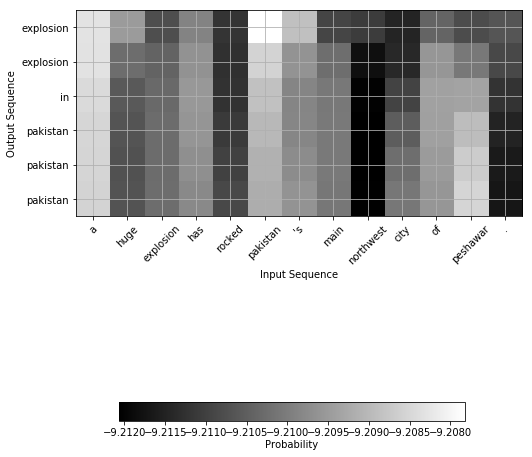

In [29]:
text = 'a huge explosion has rocked pakistan \'s main northwest city of peshawar .'
test_data_vector = X_test[99:100,:]
viz.attention_map(text,test_data_vector,idx2word)

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


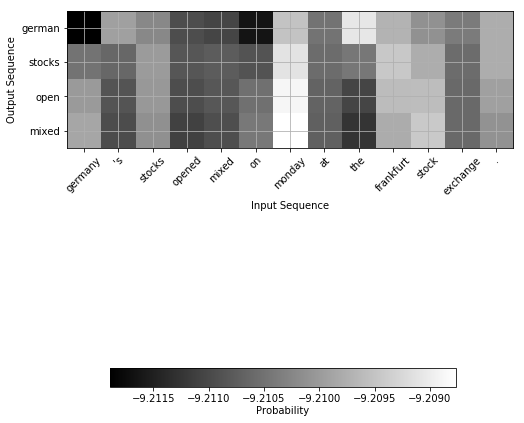

In [42]:
# perfect
text = 'germany \'s stocks opened mixed on monday at the frankfurt stock exchange .'
test_data_vector = X_test[4089:4090,:]
viz.attention_map(text,test_data_vector,idx2word)

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


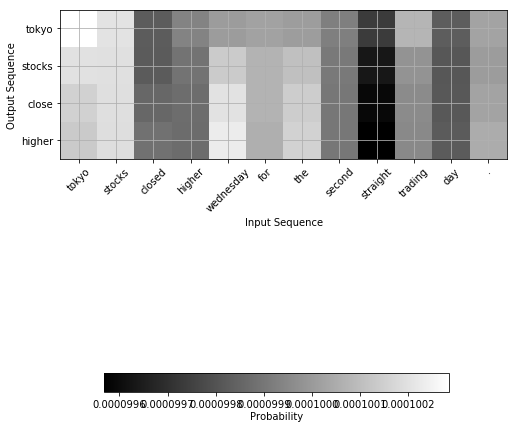

In [83]:
# perfect
text = 'tokyo stocks closed higher wednesday for the second straight trading day .'
test_data_vector = X_test[4282:4283,:]
viz.attention_map(text,test_data_vector,idx2word)

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


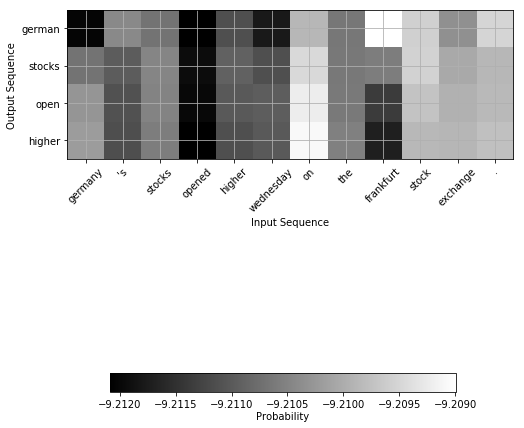

In [46]:
# perfect
text = 'germany \'s stocks opened higher wednesday on the frankfurt stock exchange .'
test_data_vector = X_test[6718:6719,:]
viz.attention_map(text,test_data_vector,idx2word)

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


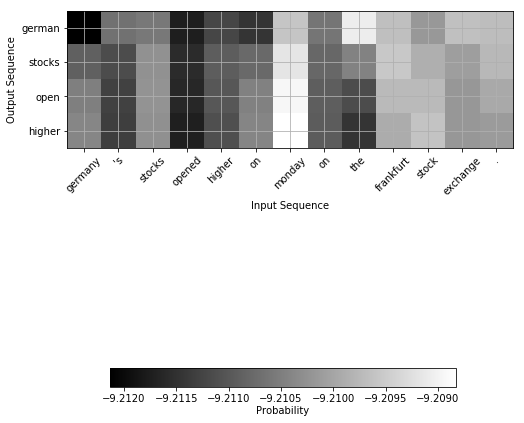

In [48]:
# perfect
text = 'germany \'s stocks opened higher on monday on the frankfurt stock exchange .'
test_data_vector = X_test[6719:6720,:]
viz.attention_map(text,test_data_vector,idx2word)

### Bad

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


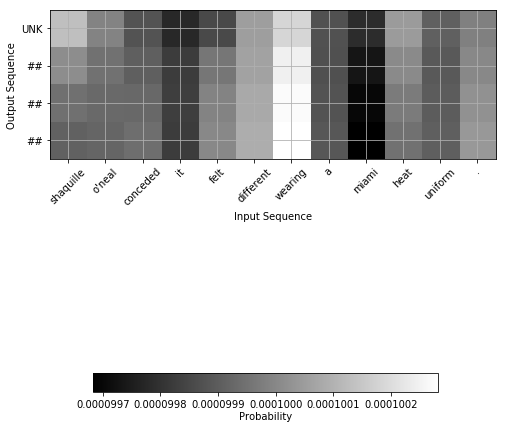

In [48]:
text = 'shaquille o\'neal conceded it felt different wearing a miami heat uniform .'
test_data_vector = X_test[2454:2455,:]
viz.attention_map(text,test_data_vector,idx2word)

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


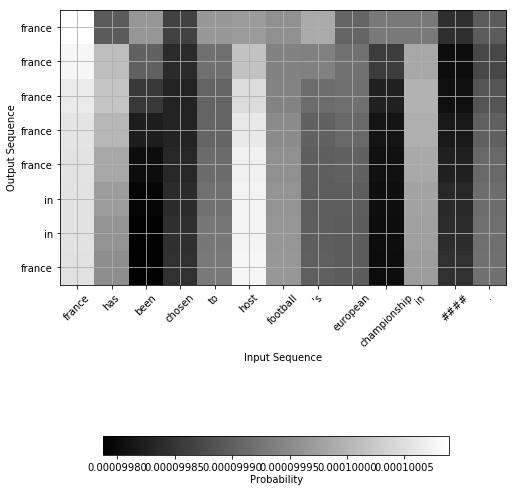

In [50]:
text = 'france has been chosen to host football \'s european championship in #### .'
test_data_vector = X_test[2679:2680,:]
viz.attention_map(text,test_data_vector,idx2word)

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


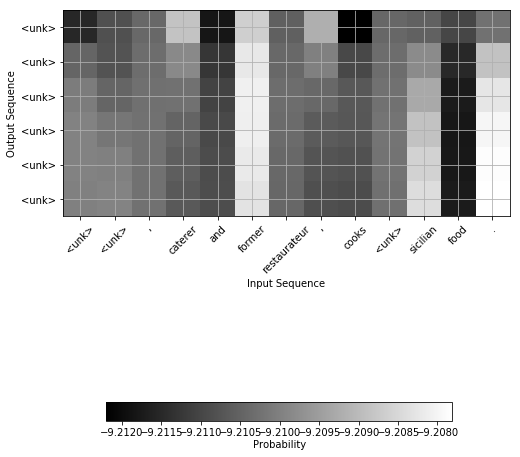

In [51]:
text = '<unk> <unk> , caterer and former restaurateur , cooks <unk> sicilian food .'
test_data_vector = X_test[5818:5819,:]
viz.attention_map(text,test_data_vector,idx2word)

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


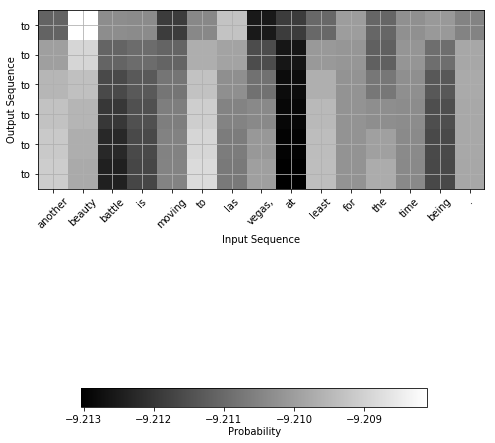

In [50]:
text = 'another beauty battle is moving to las vegas, at least for the time being .'
test_data_vector = X_test[6912:6913,:]
viz.attention_map(text,test_data_vector,idx2word)

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


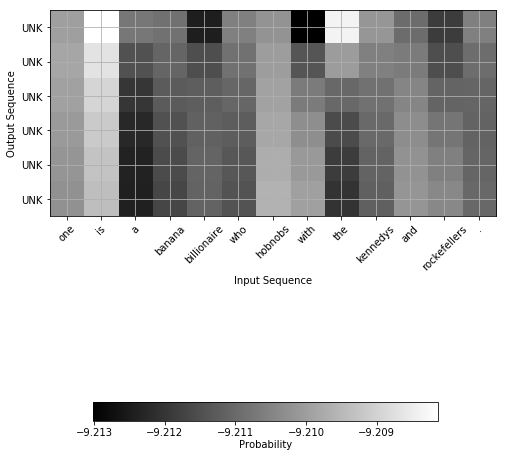

In [49]:
text = 'one is a banana billionaire who hobnobs with the kennedys and rockefellers .'
test_data_vector = X_test[6999:7000,:]
viz.attention_map(text,test_data_vector,idx2word)

### Random

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


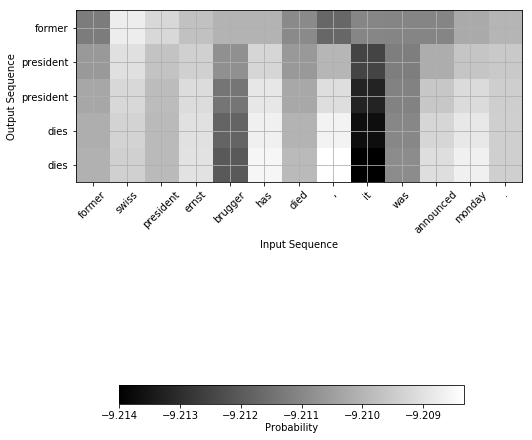

In [30]:
text = 'former swiss president ernst brugger has died , it was announced monday .'
test_data_vector = X_test[102:103,:]
viz.attention_map(text,test_data_vector,idx2word)

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


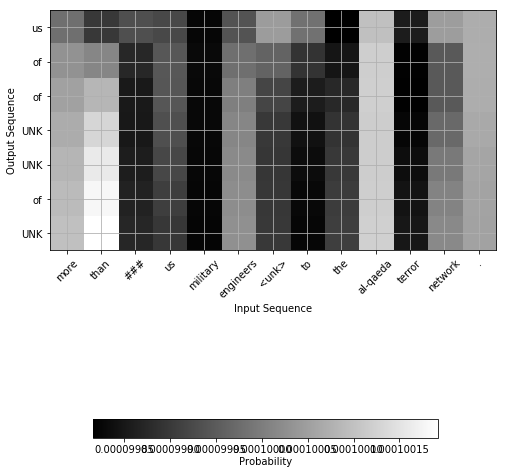

In [77]:
text = 'more than ### us military engineers <unk> to the al-qaeda terror network .'
test_data_vector = X_test[1924:1925,:]
viz.attention_map(text,test_data_vector,idx2word)

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


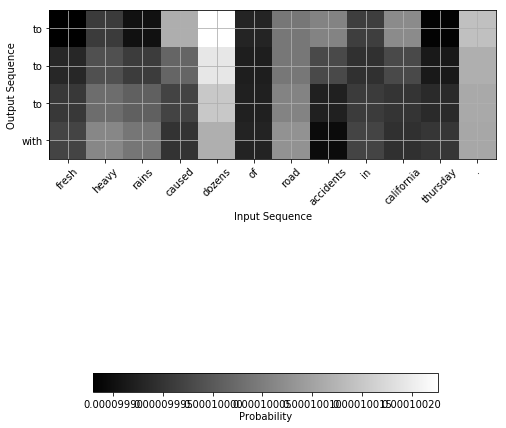

In [80]:
text = 'fresh heavy rains caused dozens of road accidents in california thursday .'
test_data_vector = X_test[2008:2009,:]
viz.attention_map(text,test_data_vector,idx2word)

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


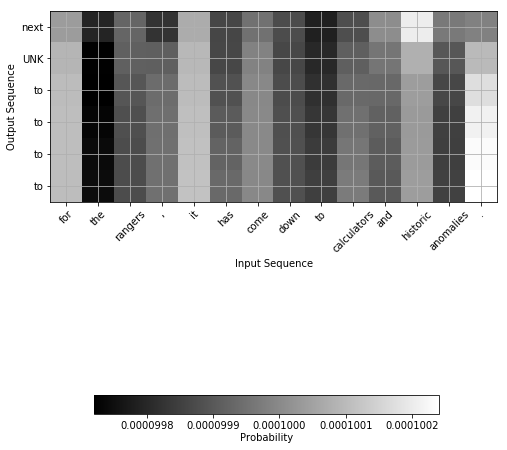

In [84]:
text = 'for the rangers , it has come down to calculators and historic anomalies .'
test_data_vector = X_test[3573:3574,:]
viz.attention_map(text,test_data_vector,idx2word)

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


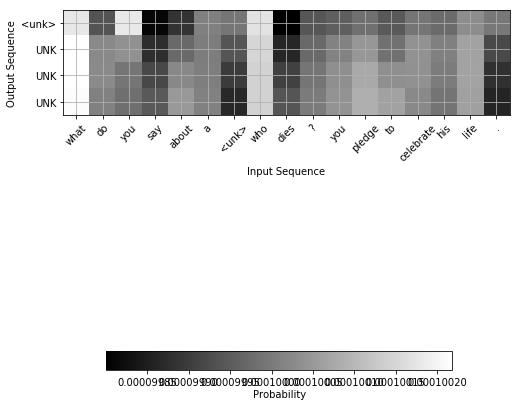

In [81]:
text = 'what do you say about a <unk> who dies ? you pledge to celebrate his life .'
test_data_vector = X_test[5740:5741,:]
viz.attention_map(text,test_data_vector,idx2word)

# Analysis

### Discuss how the attention weights show whether the system is working for these examples:
X-axis of the graph of the graph is the input article, and Y-axis is the output predicted title. The graph shows the probability of words in Y-axis appear in the prediction when words in X-axis appear in the input article. White implies high probability and black implies low probability. For both good and bad examples, graphs have a lot of white squares which implies high co-occurrence probabilities between each pair of words. Attention weights is one way to make prediction but most output does not make seanse. 


### Identify the problems that your system has the most trouble with. 
From the good prediction examples, we can see that the model predicts titles relatively well in the stock market field because there is a large portion of article data in the field of stock market. Most stock market articles and titles have the same format, and so after training the model, the prediction titles are great and some are even perfectly matched with the true titles. However, some predictions are totally opposite to the true titles in the semantic meaning or have wrong objects (like country, city, high or low, fund or stock, open or end). More data and more training are needed to improve the model. Comparing to market news, sports news is much harder to predict summary information because of lack of a clear format. Other daily news, like politic news, are more free in title and in the first sentence of the news, and are also hard to generate summary information. 

Also, the neural network mechanism tends to fill in details when details are missing. For example, ‘the jse all-share index dropped by #.## percent to ####.## on wednesday .” the attention model predicts ‘shenzhen stocks exchange down’. The true title is ‘jse ends lower wednesday’. JSE index represents the performance of South African companies and has nothing to relate with Shenzhen stocks. These errors happen most often when the number of decoding beams is small, since the model stops considering the decoding where the sentence ends early before outputting the made up details.

Some mistakes in the predictions are obvious. A large part of the predictions with attention or without attention have the problem of repetition of words, like ‘n’t n’t n’t n’t n’t n’t n’t n’t n’t n’t n’t UNK UNK’, and ungrammaticality, like ‘markets malaysia malaysia in’. Predictions have a lot of proposition words, like ‘to’, ‘of’ and ‘in’, and sometimes only have proposition words in the prediction model which make the predictions have no meaning at all. Also, because of the restriction of vocabulary size, there are a lot of ‘UNK’ and ‘<unk>’ in the predictions, which make the predictions harder to understand. Syntactic problems are hard to see from these two models, since there are not enough meaningful words in the predictions. 

The rogue score of the attention model is low and is hard to improve under the limitation of memory and training speed. The rouge score of the attention model is not much higher than the rouge score of the model without attention. Looking into the prediction titles, the model with attention does not perform better than the model without the attention. 

Models use abstractive approach most of the time, and use lexical substitutions, generalizing, compressing to generate prediction titles. The length of titles are shorter than the length of articles, and title words are not directly from article words but semantically generalized from article. 

### Compare your different system outputs to reveal the pros and cons of each.
Uni LSTM without attention model is fast to compile and train, and is easy to overfit. Can only generate good summary for articles have a specific format and have a lot of similar training data. Even with double vocabulary size, Uni LSTM without attention model cannot capture more information as expected. 
Training speed of Uni LSTM with attention model is much lower than without Attention when giving the same parameters. With smaller vocabulary size, batch size, number of layer and epochs, Uni LSTM with attention model predicts a little bit better than  Uni LSTM without attention model. If we have enough memory size, and take more time to train  Uni LSTM with attention model, predictions would get much better. 
		





Select one of the problems that you identified and provide a proposal for what you would do to correct the problem. 

### Background / Problem Statement  
News editors from different news categories do not use language in exactly the same way. Each branch of news have its own way to deliver the information. Think about the difference between markets news and political news, or scientific reports and sports news. There are big differences in the vocabulary, tone, formality of language, and style of content structured. Models perform best if they are trained and tested on the news in the same category. With enough training, the model will capture details, like politicians, organizations, and countries.  

In the given dataset, news categories are mixed, including markets, education, politics, sports and more. The data is imbalanced. Most news are markets data and both models predict much better in market news than other news. Some predictions in political news are correct. Predictions in other fields are extremely bad, and usually give predictions with ‘UNK’ and some preposition words, which are unreadable at all. However, this also make sense because news in markets usually have the same format. The first sentence addresses information of country, date and trend directly and clearly. The title is a straightforward paraphrase of the first sentence. With the same format, the models learn well in markets mews.  

### Object / Goal
Both models built above do not perform very well. The accuracies on test data are about 16%. In order to improve the model in generating news title in field other than markets, the model need to learn more information about other fields. 

### Methodology
The simplest way to improve the quality of the prediction titles is to train the model on more data, but at the same time we need to consider about the quality of the data. If new data is still unbalanced, the improvement of the model prediction would not be significant. I come up with 3 approaches to improve the model. 
 
First, to reduce the appearance of ‘#’ in the prediction of summary title, I will keep ‘#’ in the form of numbers in the input article and title, and keep ‘##.##’ in number with decimal places. This replacement distinguishes ‘#’ and will have relative lower probability between numbers and other words.  When using ‘#’, high frequency of ‘#’ makes it having high probability to occur with many words, which we don’t want in the prediction. Both model of Uni LSTM with and without Attention will have less predictions that only have ‘#’ in it, and will have predictions on stock price, date, time, and frequency.
Second, I will add encoder and decoder pre-training. Our data only use the first sentence of news as the input. However, not every news has summary in the first sentence. Usually, more information is in the following two sentences, and sometimes the last sentence of the news gives the summary. Pre-training subsets of the model on full documents will utilize the rest of the text. Information capturing from the pre-training would be much more than information in the first sentence. 

Third, I will try Bi-Directional RNN and LSTM when building the attention model since more information would be available. Two models built above are both Uni-Directional, and compute the attention weight for the current input word given the current and previous words. Adding the information of the following words, the Bi-Directional model will make network easier to decide which values to assign the neurons. 

It is not guarantee that combining all  three approaches in the same model would give the best result, and more tests are need to get the best model. 

### Reference  
Tilk, Ottokar & Alumäe, Tanel. (2017). Low-Resource Neural Headline Generation.    
https://arxiv.org/pdf/1707.09769.pdf  

Lopyrev, Konstantin. Generating News Headlines with Recurrent Neural Networks.  
https://nlp.stanford.edu/courses/cs224n/2015/reports/1.pdf  

https://www.elsevier.com/connect/new-open-access-resource-will-support-text-mining-and-natural-language-processing  


# Beam Search on the Decoder
resource: 
https://gist.github.com/nikitakit/6ab61a73b86c50ad88d409bac3c3d09f   

https://github.com/ottokart/beam_search/blob/master/beam_search.py

In [ ]:
hypotheses = beam_search(model.initial_state_function, model.generate_function, X, y_ix_to_word['<S>'], y_ix_to_word['</S>'])

for hypothesis in hypotheses:
    generated_indices = hypothesis.to_sequence_of_values()
    generated_tokens = [reverse_decoder_vocabulary[i] for i in generated_indices]
    print(" ".join(generated_tokens))
    
def beam_search(initial_state_function, generate_function, X, start_id, end_id, beam_width=4, num_hypotheses=1, max_length=50):

    if isinstance(X, list) or X.ndim == 1:
        X = np.array([X], dtype=np.int32).T
    assert X.ndim == 2 and X.shape[1] == 1, "X should be a column array with shape (input-sequence-length, 1)"

    next_fringe = [Node(parent=None, state=initial_state_function(X), value=start_id, cost=0.0, extras=None)]
    hypotheses = []

    for _ in range(max_length):

        fringe = []
        for n in next_fringe:
            if n.value == end_id:
                hypotheses.append(n)
            else:
                fringe.append(n)

        if not fringe or len(hypotheses) >= num_hypotheses:
            break

        Y_tm1 = np.array([n.value for n in fringe], dtype=np.int32)
        state_tm1 = np.array([n.state for n in fringe], dtype=np.float32)
        state_t, p_t, extras_t = generate_function(X, Y_tm1, state_tm1)
        Y_t = np.argsort(p_t, axis=1)[:,-beam_width:] # no point in taking more than fits in the beam

        next_fringe = []
        for Y_t_n, p_t_n, extras_t_n, state_t_n, n in zip(Y_t, p_t, extras_t, state_t, fringe):
            Y_nll_t_n = -np.log(p_t_n[Y_t_n])

            for y_t_n, y_nll_t_n in zip(Y_t_n, Y_nll_t_n):
                n_new = Node(parent=n, state=state_t_n, value=y_t_n, cost=y_nll_t_n, extras=extras_t_n)
                next_fringe.append(n_new)

        next_fringe = sorted(next_fringe, key=lambda n: n.cum_cost)[:beam_width] # may move this into loop to save memory

    hypotheses.sort(key=lambda n: n.cum_cost)
    return hypotheses[:num_hypotheses]